# Evaluating Dribbling Ability

# Introduction <a class='anchor' id='introduction'></a>
This notebook contains a pipeline to evaluate carries with respect to their risk (probability of failure based on similar carries) and value (combination of advance towards goal and reduction of opponent pressure).

It is built on the xlsx-results given by the notebook 2_preprocessing.

In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2
%autoreload
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
from ipywidgets import *

In [2]:
%pip install xlsxwriter

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
import xgboost as xgb
from mplsoccer import Pitch, FontManager, Sbopen
import matplotlib.patheffects as path_effects
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import math
import shap
import pickle
import os
from tqdm import tqdm
from pandas.api.types import is_numeric_dtype
from sklearn.cluster import KMeans
import matplotlib.colors as mcolors
import matplotlib.patheffects as path_effects
from scipy.interpolate import interp1d
from matplotlib.ticker import FuncFormatter
import webp
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image, ImageDraw, ImageFilter

warnings.filterwarnings('ignore')

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Define custom colors
orange =  (240/255, 125/255, 0)
blue = (0/255, 60/255, 80/255)
grey = (153/255, 177/255, 185/255)
black = (0,0,0)
orangeRGBA =  (240, 125, 0, 255)
blueRGBA = (0, 60, 80, 255)
greyRGBA = (153, 177, 185, 255)
blackRGBA = (0,0,0, 255)

# Helper functions 

In [4]:
def plot_heatmap(x_coordinates, y_coordinates, values, statistic, label, percentages=False, extra_bins_for_penalty_area=False,
                vmax = None, vmin = None, show_values = True):
    pitch = Pitch(pitch_type='statsbomb',line_zorder=2)
    if extra_bins_for_penalty_area:
        bins = (np.array([0.,20.,40.,60.,80.,100,110.,120.]),np.array([0.,16.,32.,48.,64.,80.])) 
    else:
        bins = (np.array([0., 20,40., 60, 80., 100, 120.]),np.array([0.,16.,32.,48.,64.,80.])) 


    colors = [blue,orange]  # Blue to orange

    # Create a custom colormap
    custom_cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors)

    
    bin_statistic = pitch.bin_statistic(x_coordinates, y_coordinates, values=values,
                                              statistic=statistic, bins=bins)
    
    if percentages:
        str_format = '{:.0%}'
    else:
        if bin_statistic["statistic"].max()>=100:
            str_format='{:.0f}'
        elif bin_statistic["statistic"].max()>=10:
            str_format='{:.2f}'

        else:
            str_format='{:.2}'

    fig, ax = pitch.draw(figsize=(15,10))
    dribble_heatmap = pitch.heatmap(bin_statistic, ax=ax, cmap=custom_cmap, vmin = vmin, vmax= vmax)

    
    if percentages:
        fmt = lambda x, pos: '{:.0%}'.format(x)
    else:
        fmt = lambda x, pos: str_format.format(x)
    
    cbar = fig.colorbar(dribble_heatmap, ax=ax, 
                        shrink=0.75,
                        format=FuncFormatter(fmt))
    cbar.outline.set_edgecolor('#efefef')
    cbar.ax.yaxis.set_tick_params(color='#efefef')
    ticks = plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='black')

    if show_values:


        path_eff = [path_effects.Stroke(linewidth=1.5, foreground='black'),
                    path_effects.Normal()]



        labels = pitch.label_heatmap(bin_statistic, color='#f4edf0', fontsize=12,
                                     ax=ax, ha='center', va='center',
                                     str_format=str_format, 
                                     path_effects=path_eff)
    plt.title(label)

In [5]:
##################
# Insert portraits
def get_picture(name):
    #path = "pictures/{}.png".format(name.title())
    #im = plt.imread(path)
    path = "pictures/{}.webp".format(name.title())
    im = webp.load_image(path, 'RGBA')
    
    # crop image to upper middle
    #im_crop = im.crop((160, 0, 480, 320))

    # crop circular
    mask = Image.new("RGBA", [320, 320], (0,0,0,0))
    draw = ImageDraw.Draw(mask)
    draw.ellipse((0,0,320,320), fill=(255,255,255,255))
    circular_image = Image.new("RGBA", (320, 320),(0,0,0,0))
    circular_image.paste(im, mask=mask)
    
    # create circle and merge
    thickness=16
    circle_color = blue
    circle = Image.new("RGBA", [320, 320], (0,0,0,0))
    draw2 = ImageDraw.Draw(circle)
    draw2.ellipse((0,0,320,320), fill=blueRGBA)
    draw2.ellipse((thickness,thickness,320-thickness,320-thickness), fill=(0,0,0,0))
    #circle.filter(ImageFilter.GaussianBlur(thickness))
    
    circular_image.paste(circle,circle)

    return circular_image

def offset_image(coord_x, coord_y, name, ax, zoom=0.11):
    img = get_picture(name)
    im = OffsetImage(img, zoom=zoom, )
    im.image.axes = ax
    ab = AnnotationBbox(im, (coord_x, coord_y),  xybox=(0., -16.), frameon=False,
                        xycoords='data',  boxcoords="offset points", pad=0)

    ax.add_artist(ab)

In [6]:
def plot_heatmap_vmax(x_coordinates, y_coordinates, values, statistic, label, percentages=False, vmax=0.5):
    pitch = Pitch(pitch_type='statsbomb',line_zorder=2)
    bins = (np.array([0.,40.,80.,120.]),np.array([0.,18.,30.,50.,62.,80.])) 
    
    # Define custom colors
    colors = [blue,orange]  # Blue to orange

    # Create a custom colormap
    custom_cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors)

    
    bins = (np.array([0.,20.,40.,60.,80.,98.,110.,120.]),np.array([0.,12.,30.,40.,50.,68.,80.])) 
    bin_statistic = pitch.bin_statistic(x_coordinates, y_coordinates, values=values,
                                              statistic=statistic, bins=bins)
    
    if percentages:
        str_format = '{:.0%}'
    else:
        if bin_statistic["statistic"].max()>=10:
            str_format='{:.2f}'
        elif bin_statistic["statistic"].max()>=100:
            str_format='{:.0}'
        else:
            str_format='{:.2}'

    fig, ax = pitch.draw(figsize=(15,10))
    dribble_heatmap = pitch.heatmap(bin_statistic, ax=ax, cmap=custom_cmap, vmax=vmax)

    
    if percentages:
        fmt = lambda x, pos: '{:.0%}'.format(x)
    else:
        fmt = lambda x, pos: str_format.format(x)
    
    cbar = fig.colorbar(dribble_heatmap, ax=ax, shrink=0.6, format=FuncFormatter(fmt))
    cbar.outline.set_edgecolor('#efefef')
    cbar.ax.yaxis.set_tick_params(color='#efefef')
    ticks = plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='black')


    path_eff = [path_effects.Stroke(linewidth=1.5, foreground='black'),
                path_effects.Normal()]
    


    labels = pitch.label_heatmap(bin_statistic, color='#f4edf0', fontsize=12,
                                 ax=ax, ha='center', va='center',
                                 str_format=str_format, 
                                 path_effects=path_eff)
    plt.title(label)

# Load carry data


In [7]:
carries = pd.read_excel("carries.xlsx")
carries["position_group"] = carries["position_name"].apply(lambda x: x.split(" ")[-1])
carries["position_ignoring_side"] = carries["position_name"].str.replace("Right", "Outer").str.replace("Left", "Outer")


# Expected threat overview

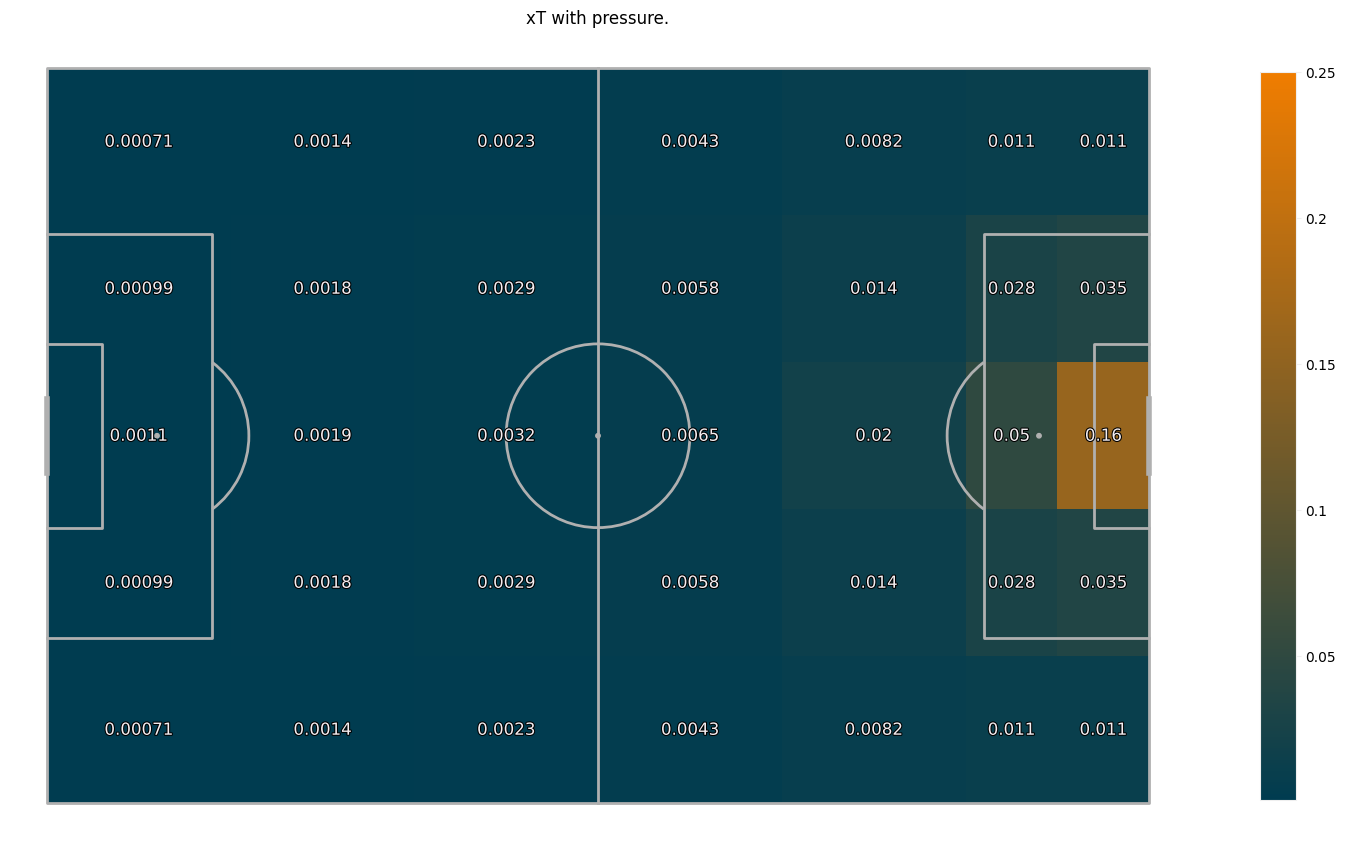

In [8]:
data = pd.read_csv("xT_pressure_women.csv", index_col=0)
data.index = np.linspace(0., 80., 20)
data.columns = np.linspace(0., 120., 30)

expanded_data = pd.melt(data.reset_index(), id_vars="index")
expanded_data = expanded_data.rename(columns={'index': 'y', 'variable': 'x', 'value': 'xT'})
expanded_data = expanded_data.astype(float)

plot_heatmap(expanded_data["x"], expanded_data["y"], expanded_data["xT"], "mean", "xT with pressure.",vmax=0.25, extra_bins_for_penalty_area=True)
plt.savefig("graphics/xT_pressure.png", dpi = 300)

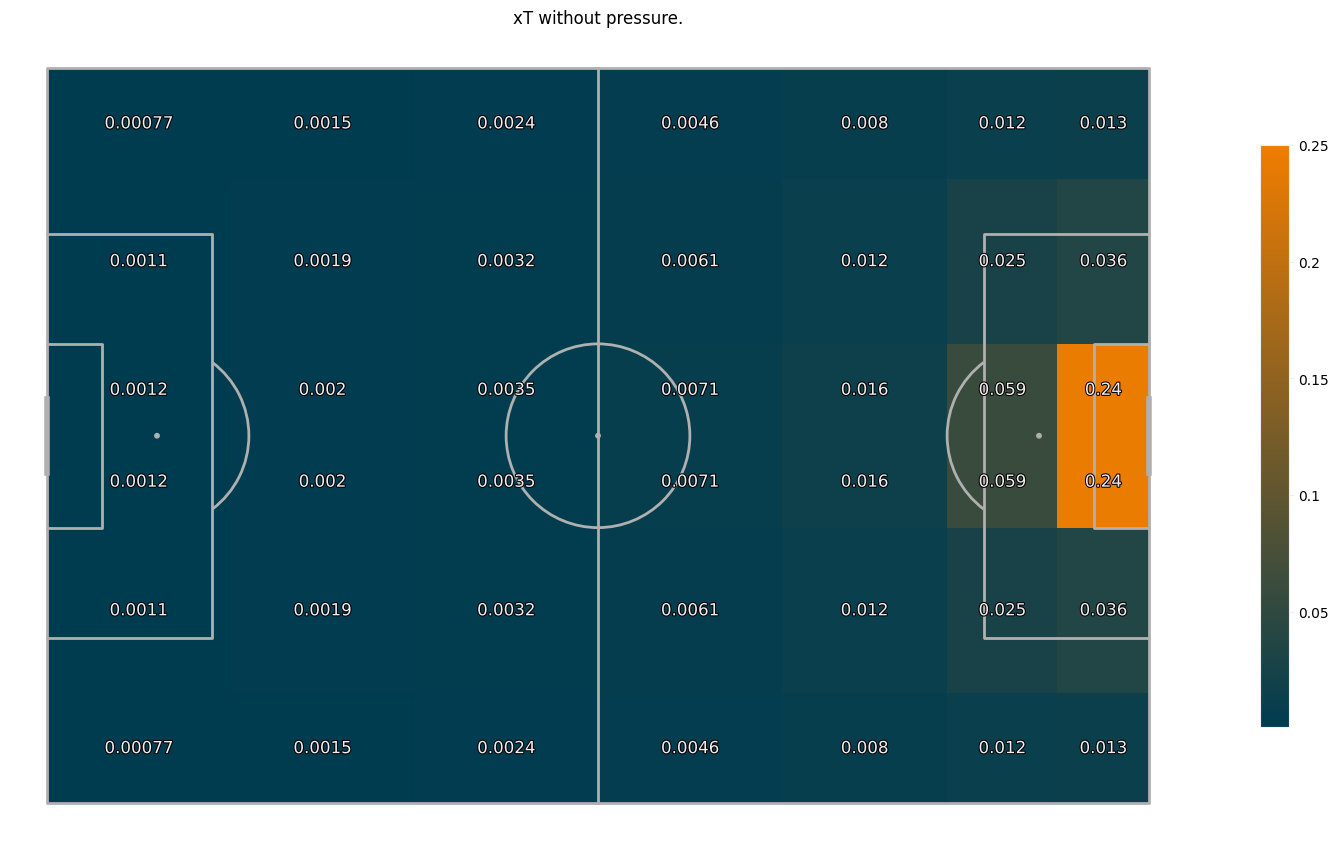

In [9]:
data = pd.read_csv("xT_no_pressure_women.csv", index_col=0)
data.index = np.linspace(0., 80., 20)
data.columns = np.linspace(0., 120., 30)

expanded_data = pd.melt(data.reset_index(), id_vars="index")
expanded_data = expanded_data.rename(columns={'index': 'y', 'variable': 'x', 'value': 'xT'})
expanded_data = expanded_data.astype(float)

plot_heatmap_vmax(expanded_data["x"], expanded_data["y"], expanded_data["xT"], "mean", "xT without pressure.",vmax=0.25)
plt.savefig("graphics/xT_no_pressure.png", dpi = 300)

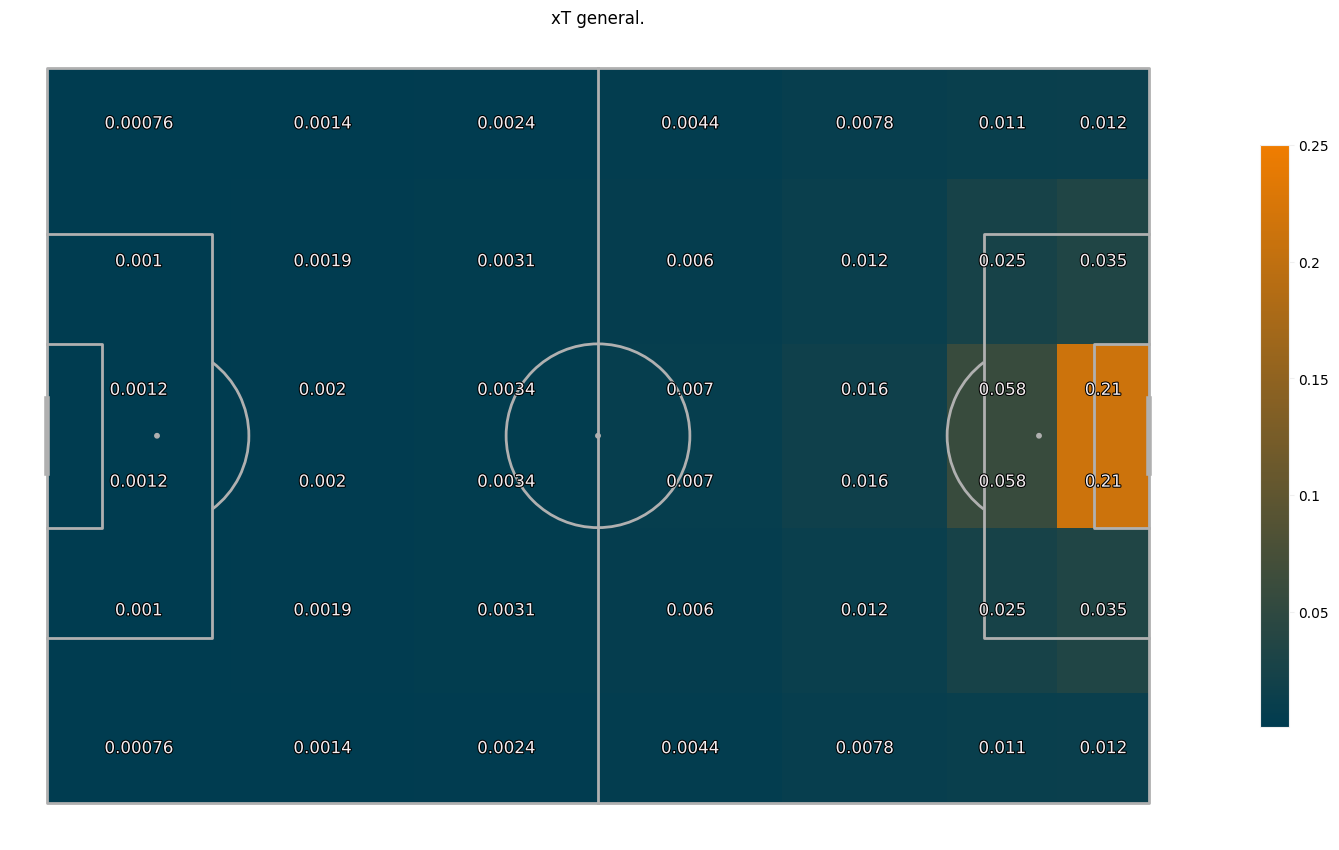

In [10]:
data = pd.read_csv("xT_general_women.csv", index_col=0)
data.index = np.linspace(0., 80., 20)
data.columns = np.linspace(0., 120., 30)

expanded_data = pd.melt(data.reset_index(), id_vars="index")
expanded_data = expanded_data.rename(columns={'index': 'y', 'variable': 'x', 'value': 'xT'})
expanded_data = expanded_data.astype(float)

plot_heatmap_vmax(expanded_data["x"], expanded_data["y"], expanded_data["xT"], "mean", "xT general.",vmax=0.25)
plt.savefig("graphics/xT_general.png", dpi = 300)

# Carries overview
Heatmaps related to xt and risk for all and specific teams.

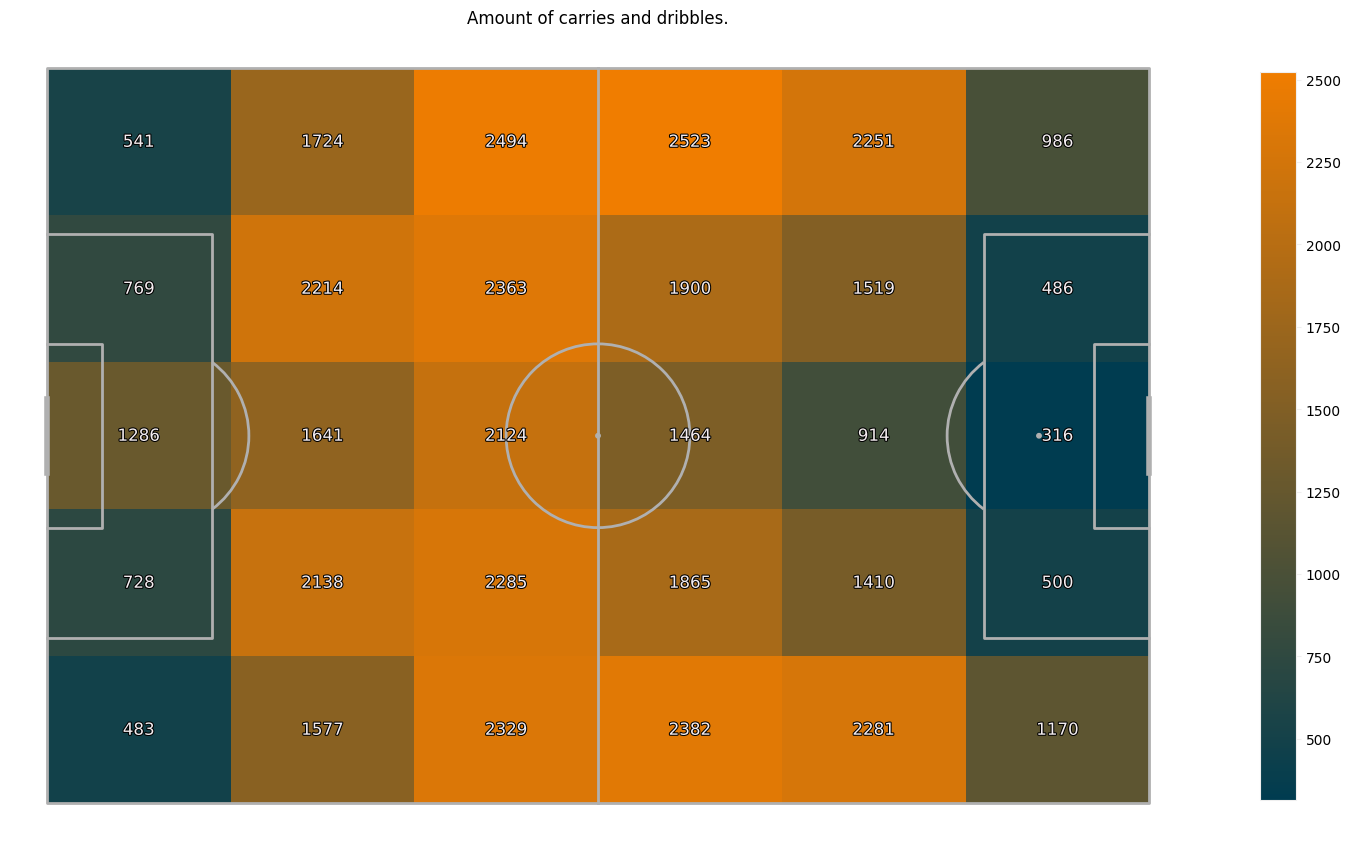

In [11]:
plot_heatmap(carries["x"], carries["y"], carries["num_carries"], "sum", "Amount of carries and dribbles.")

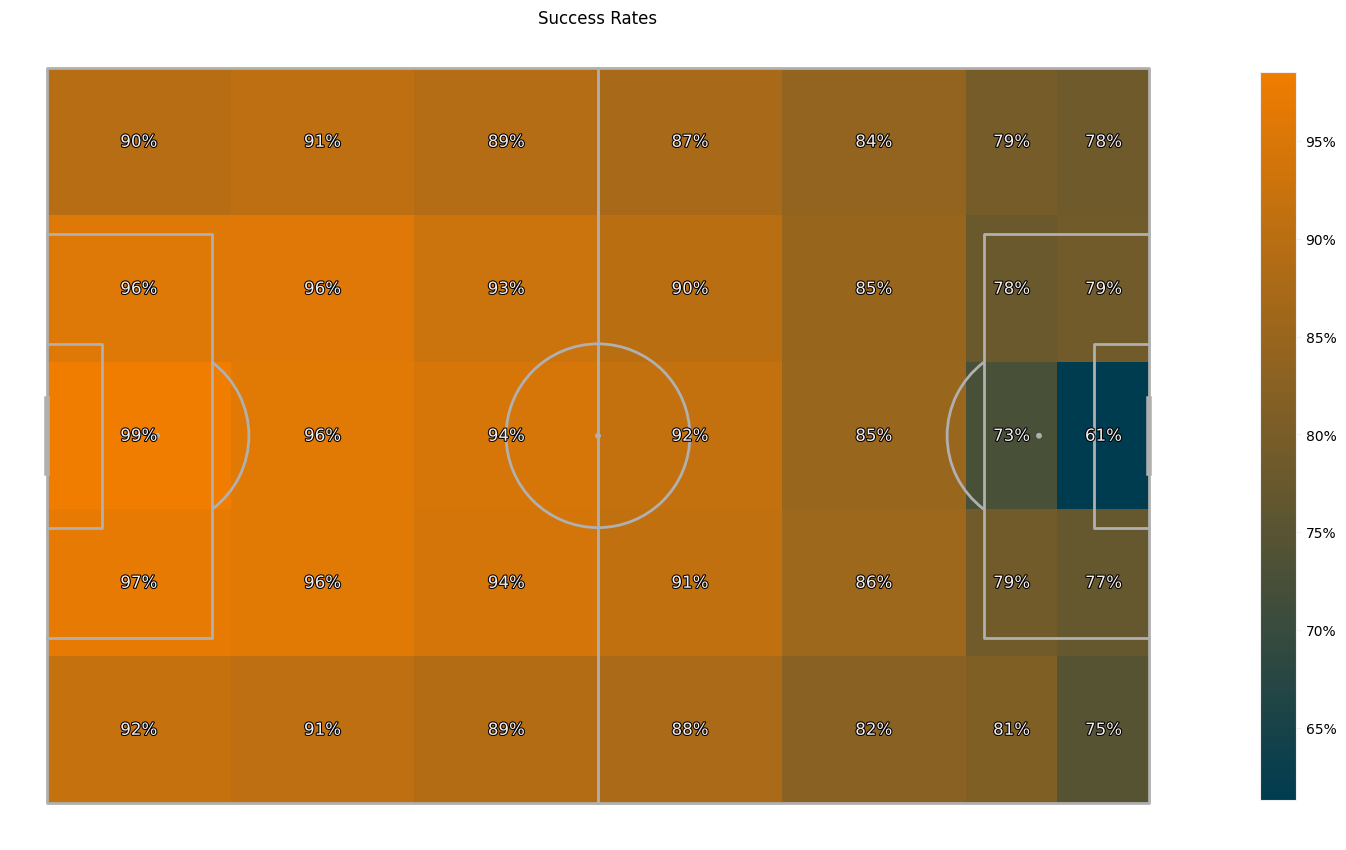

In [12]:
plot_heatmap(carries["x"], carries["y"], carries["Outcome"], "mean", "Success Rates", percentages=True, extra_bins_for_penalty_area=True)

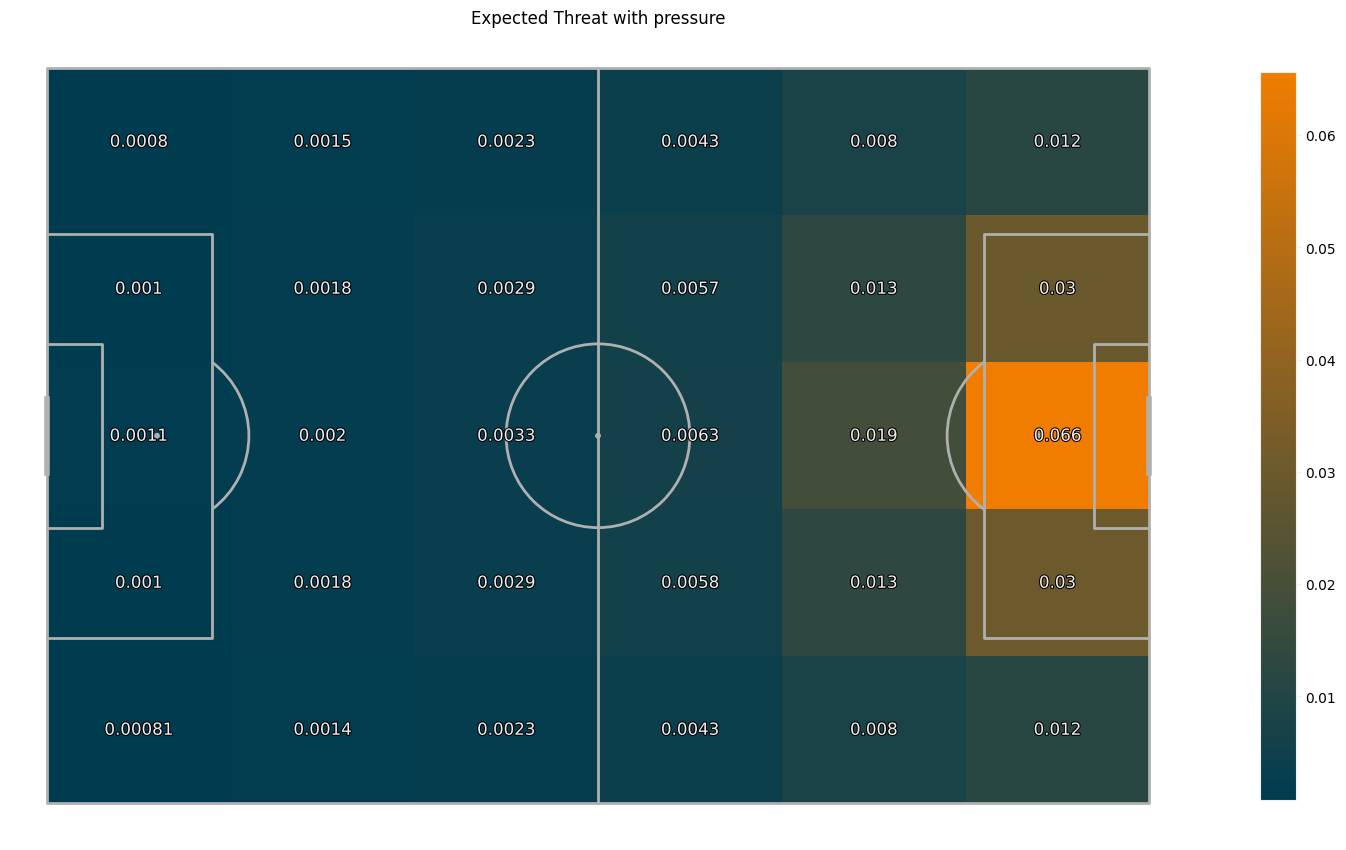

In [13]:
df_heatmap = carries[carries['tagged_pressure']==1]

plot_heatmap(df_heatmap["x"], df_heatmap["y"], df_heatmap["xT_start"], "mean", "Expected Threat with pressure")

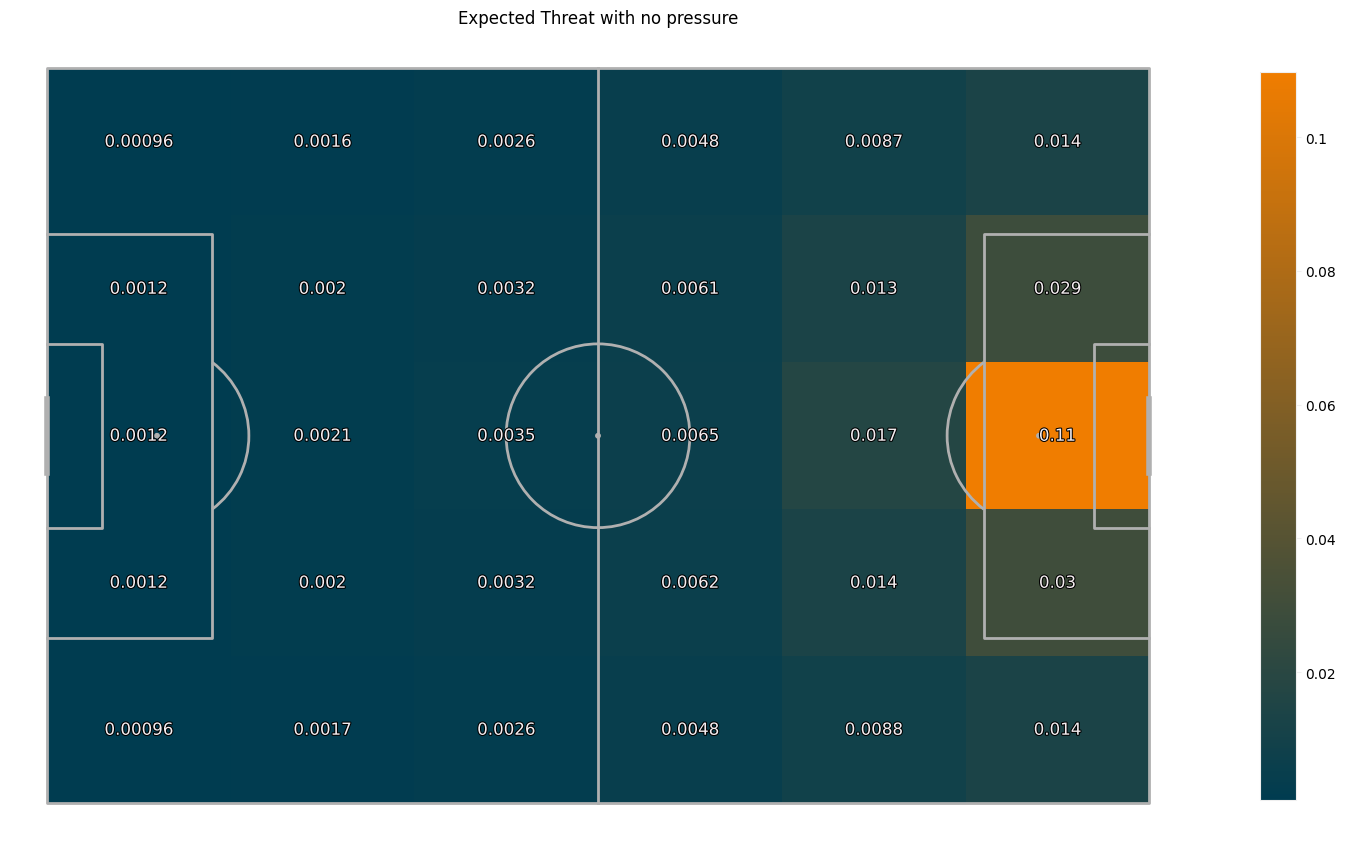

In [14]:
df_heatmap = carries[carries['tagged_pressure']==0]
plot_heatmap(df_heatmap["x"], df_heatmap["y"], df_heatmap["xT_start"], "mean", "Expected Threat with no pressure")

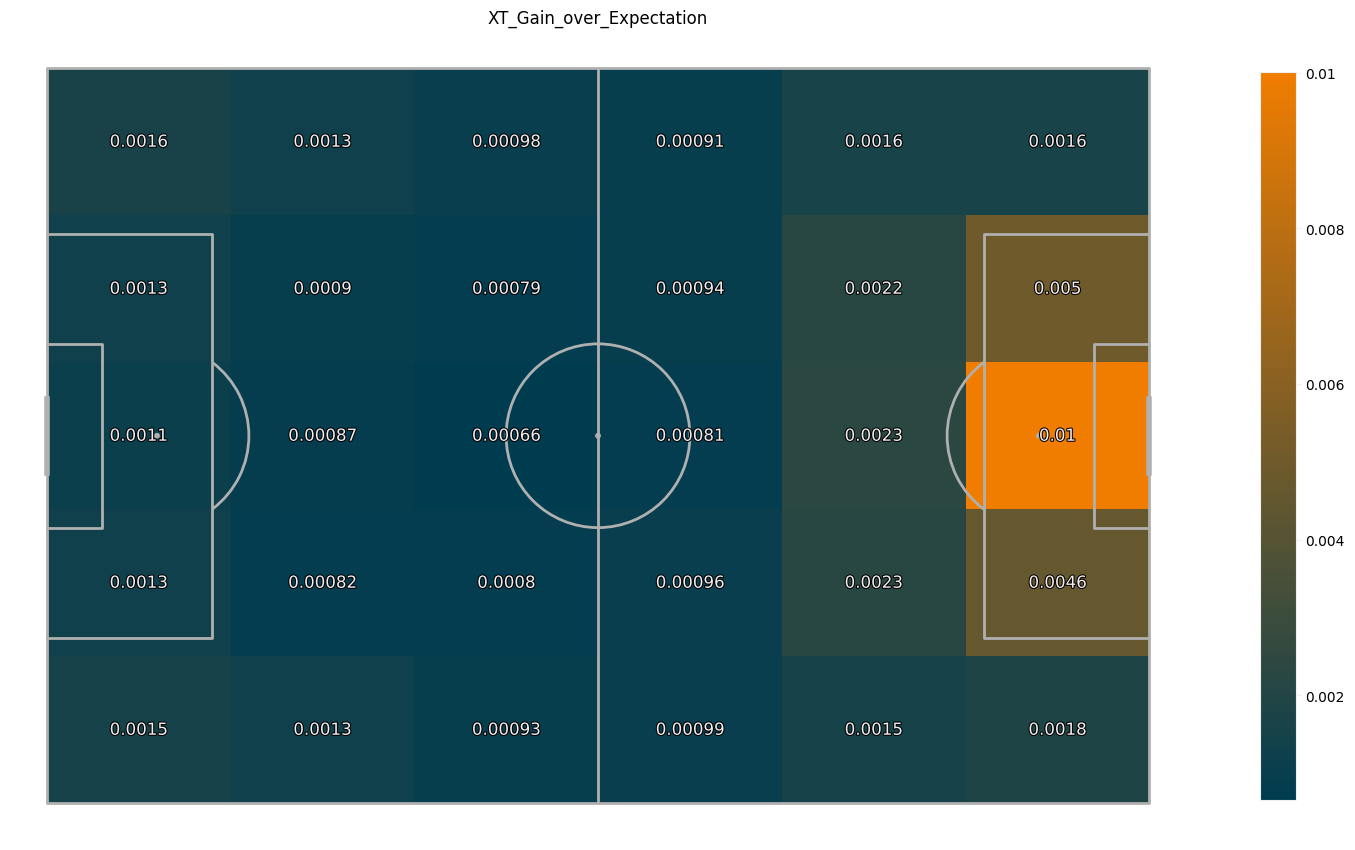

In [15]:
plot_heatmap(carries["x"], carries["y"], carries["XT_Gain_over_Expectation"], "mean", "XT_Gain_over_Expectation")

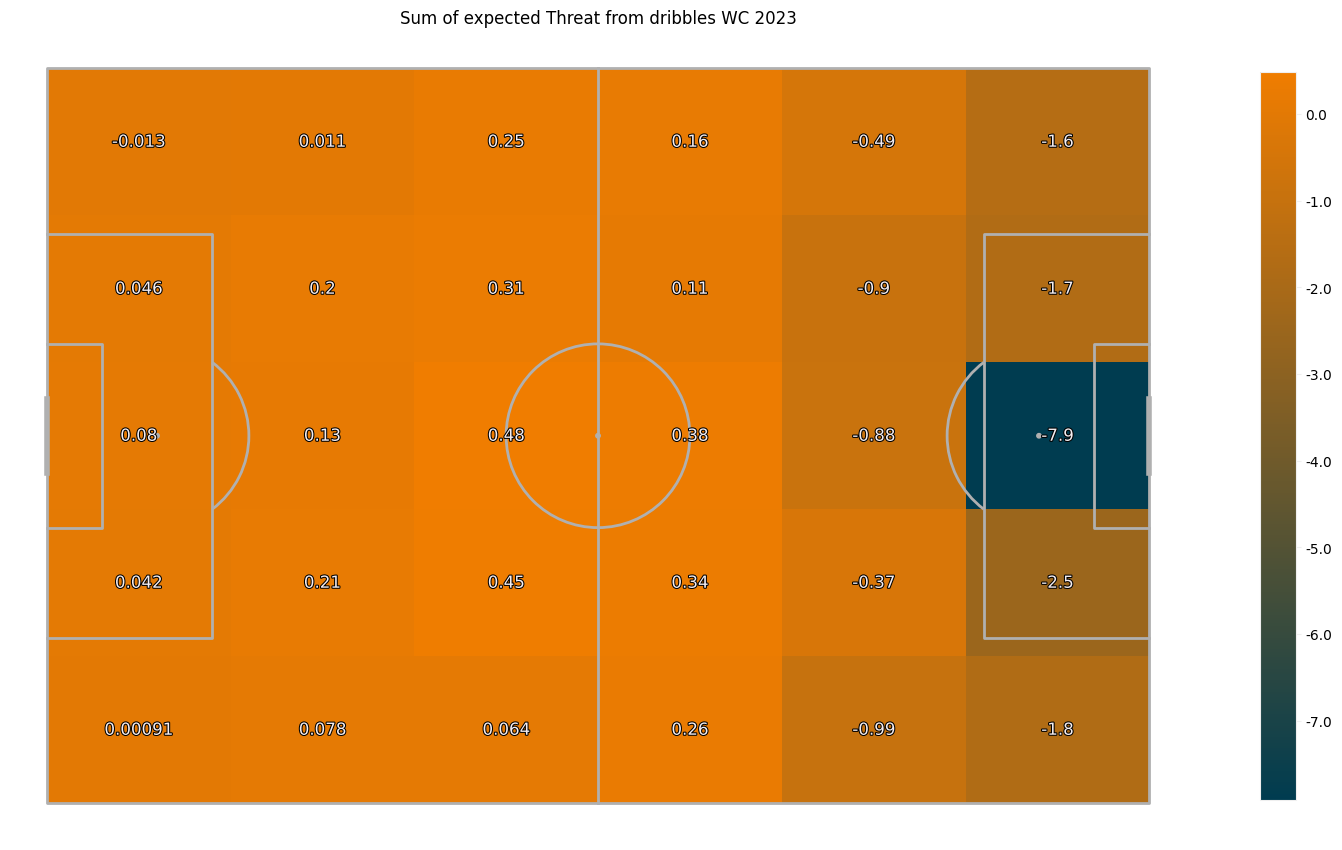

In [16]:
df_heatmap = carries
plot_heatmap(df_heatmap["x"], df_heatmap["y"], df_heatmap["xT_gain"], "sum", "Sum of expected Threat from dribbles WC 2023")

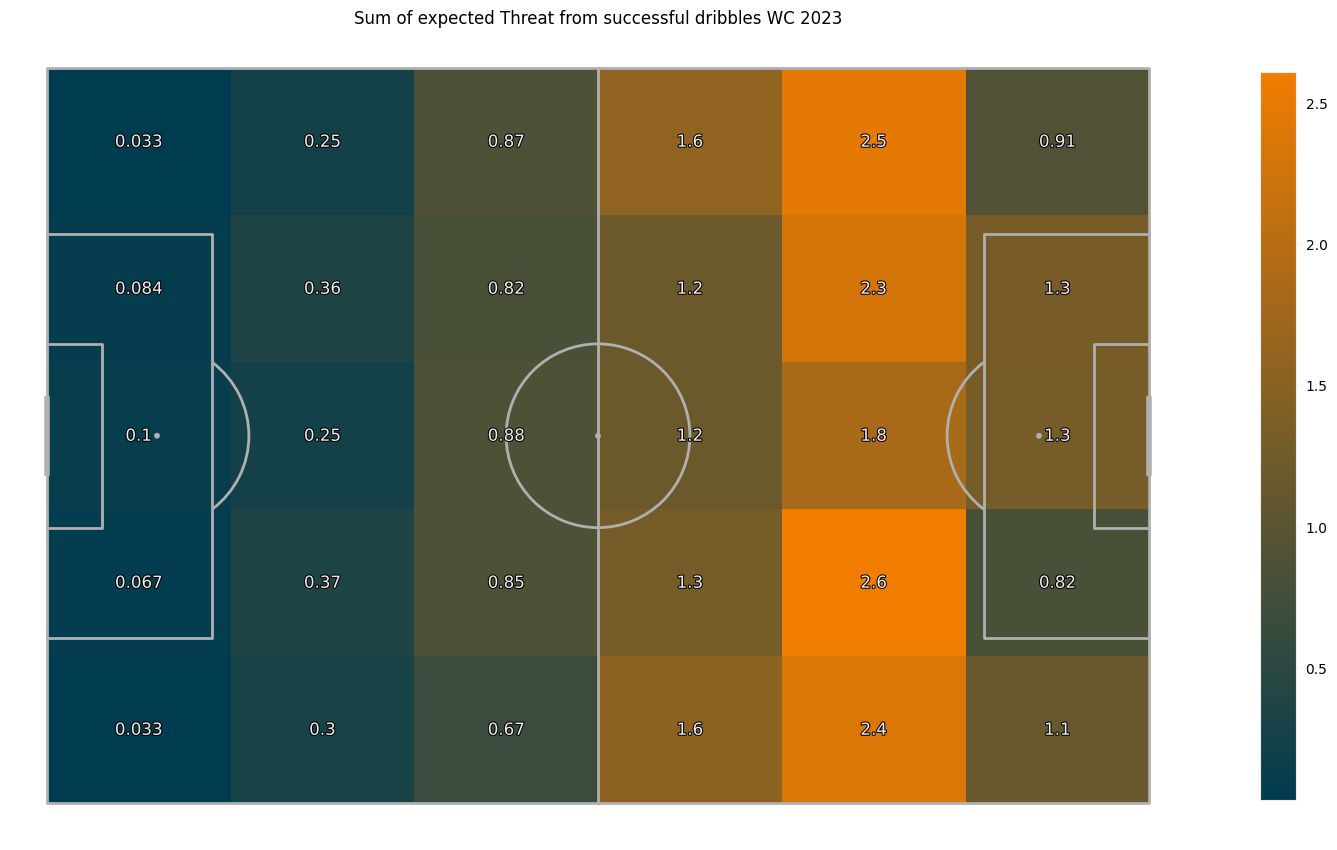

In [17]:
df_heatmap = carries[carries["Outcome"]==1]
plot_heatmap(df_heatmap["x"], df_heatmap["y"], df_heatmap["xT_gain"], "sum", "Sum of expected Threat from successful dribbles WC 2023")

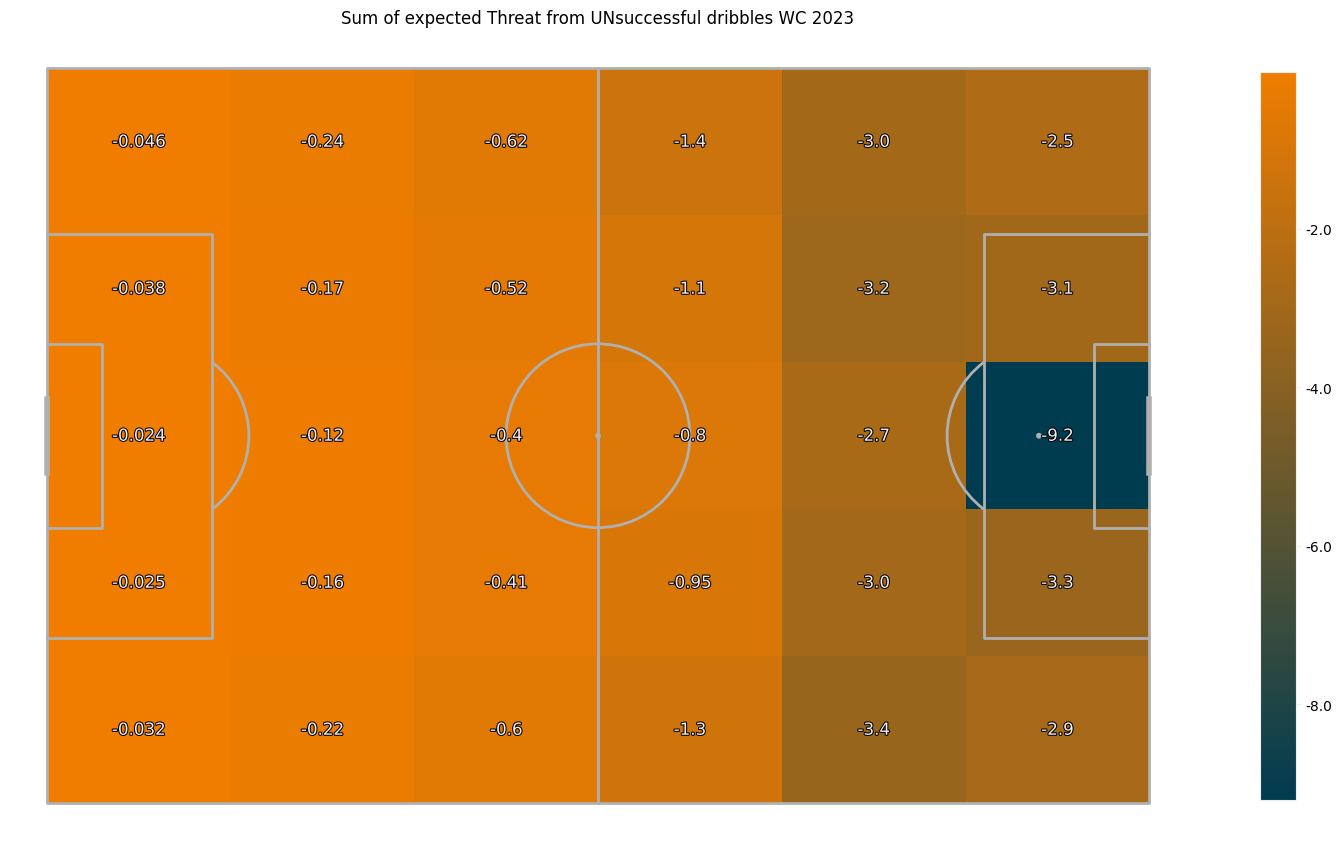

In [18]:
df_heatmap = carries[carries["Outcome"]==0]
plot_heatmap(df_heatmap["x"], df_heatmap["y"], df_heatmap["xT_gain"], "sum", "Sum of expected Threat from UNsuccessful dribbles WC 2023")

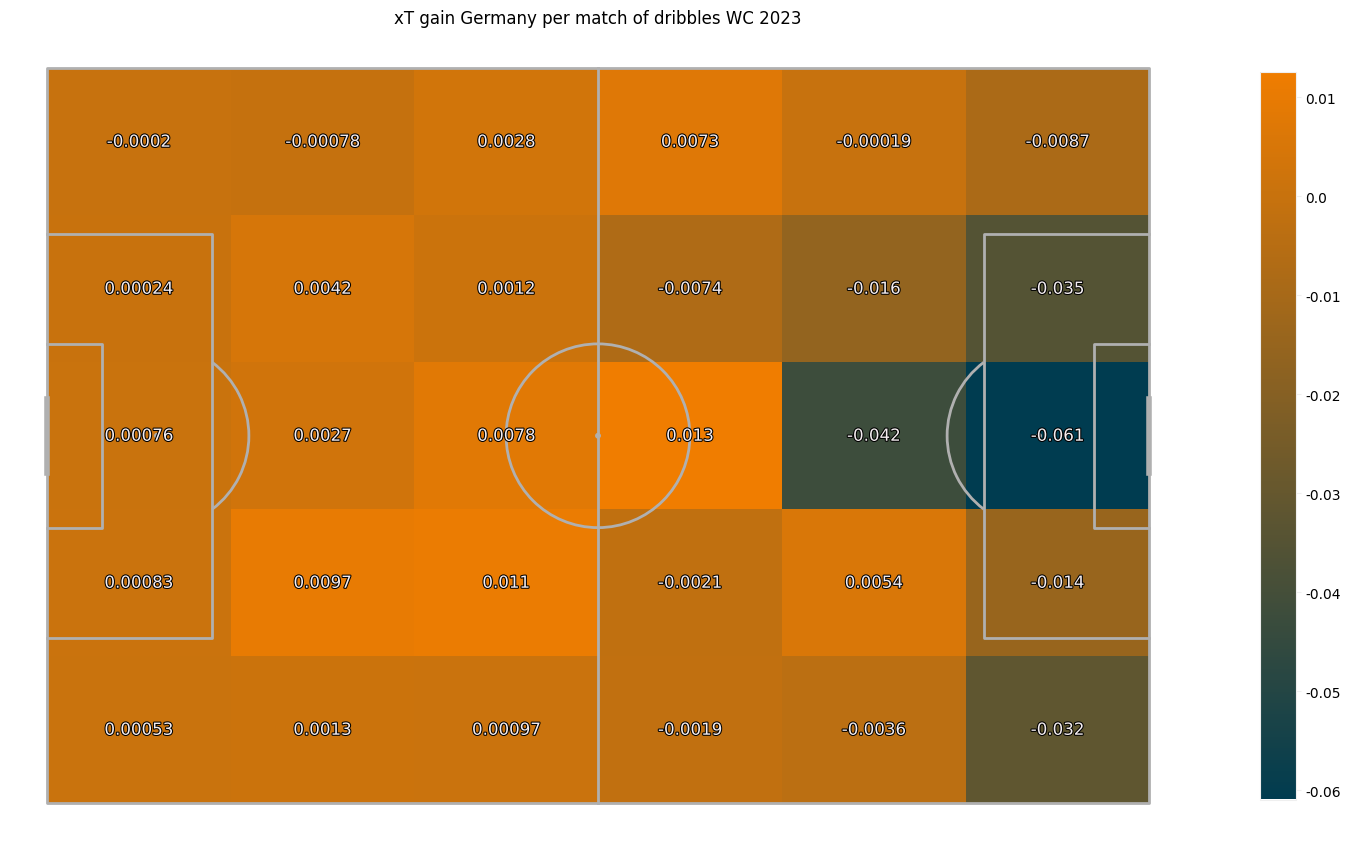

In [19]:
dribblings_germany = carries[carries['team_name'] == "Germany Women's"]

dribblings_germany["xT_gain_avg_per_match_helper"] = dribblings_germany["xT_gain"]/len(dribblings_germany["match_id"].unique())

plot_heatmap(dribblings_germany["x"], dribblings_germany["y"], dribblings_germany["xT_gain_avg_per_match_helper"], "sum", "xT gain Germany per match of dribbles WC 2023")


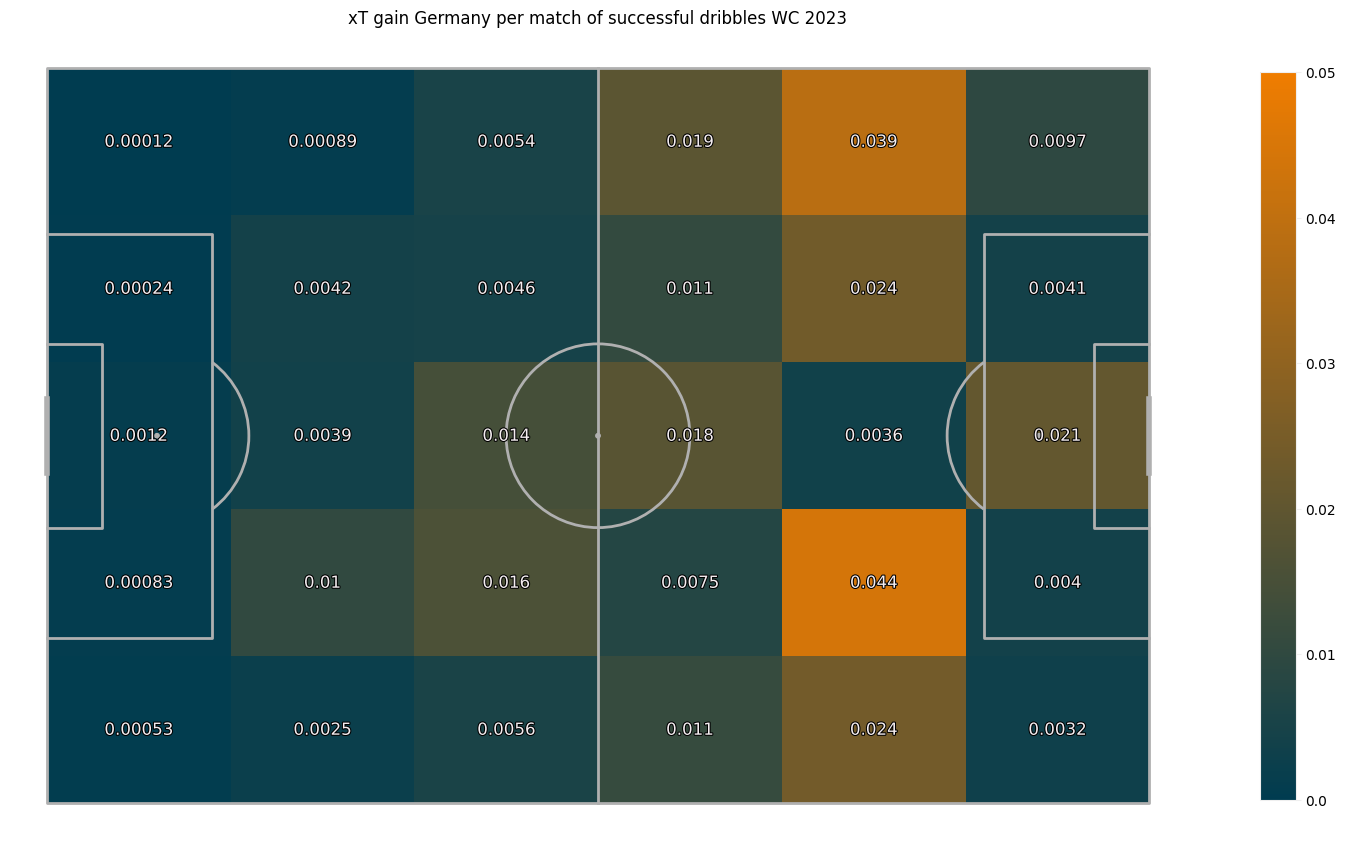

In [20]:
df_heatmap_ger_suc = dribblings_germany[dribblings_germany["Outcome"]==1].copy()

plot_heatmap(df_heatmap_ger_suc["x"], df_heatmap_ger_suc["y"], df_heatmap_ger_suc["xT_gain_avg_per_match_helper"], "sum", 
             "xT gain Germany per match of successful dribbles WC 2023",
            vmin = 0, vmax = 0.05, show_values = True)


# Values per match for playing_times

In [21]:
df_playing_time = pd.read_excel("playing_time_per_player_per_match.xlsx")
df_playing_time.rename(columns = {"position": "position_name"}, inplace=True)
df_playing_time.head(3)

,Unnamed: 0,position_name,playing_time_in_seconds,player_id,player_name,playing_time_in_minutes,playing_ratio,match_id
0,0,Right Center Back,4149,4989,Rebekah Ashley Stott,69.15,0.768333,3893787
1,0,Left Center Back,5400,5028,Katie Bowen,90.00,1.000000,3893787
2,0,Right Defensive Midfield,5400,18145,Ria Percival,90.00,1.000000,3893787


In [22]:
carries["num_carries"] = 1
carries["Outcome_over_Risk"] = carries["Outcome"] - (1-carries["Risk"])

match_vals = carries.groupby(by = ["match_id", 'player_name', "team_name", "position_name"], as_index=False).sum()
match_vals.shape

(2374, 49)

In [23]:
match_vals = match_vals.merge(df_playing_time[["match_id", "player_name", "playing_time_in_minutes", "position_name"]], 
                             on = ["match_id", "player_name", "position_name"], how = "left", validate = "many_to_one")
match_vals = match_vals[match_vals["playing_time_in_minutes"]>=60]
match_vals.shape

(1179, 50)

In [24]:
match_vals.head(3)

,match_id,player_name,team_name,position_name,Unnamed: 0,id,period,minute,second,type_name,...,xT_gain_nonnegative,xT_gain_successful_dribbles,xT_gain_incl_punishment,Expected_XT_Gain,XT_Gain_over_Expectation,xt_norm,Outcome_over_Risk,position_group,position_ignoring_side,playing_time_in_minutes
0,3893787,Ada Stolsmo Hegerberg,Norway Women's,Center Forward,24294,c8d8b7d2-201c-4de4-8e58-a845622be65afcabc333-4...,17,529,346,CarryCarryCarryCarryCarryCarryCarryCarryCarryC...,...,0.007227,0.005245,-0.022148,-0.042650,0.025253,8.168190,1.314691,ForwardForwardForwardForwardForwardForwardForw...,Center ForwardCenter ForwardCenter ForwardCent...,90.0
1,3893787,Alexandra Riley,New Zealand Women's,Left Back,32265,9072ebd2-13d9-49e2-9709-b013fa4f0c5a4a6b5cfd-6...,28,824,757,CarryCarryCarryCarryCarryCarryCarryCarryCarryC...,...,0.017529,0.013288,-0.004398,-0.021196,0.019760,15.016252,1.973915,BackBackBackBackBackBackBackBackBackBackBackBa...,Outer BackOuter BackOuter BackOuter BackOuter ...,90.0
3,3893787,Aurora Watten Mikalsen,Norway Women's,Goalkeeper,22928,2c0d254d-cecd-4e97-b0bd-575e4fc6de0ea50c5f2e-4...,22,667,450,CarryCarryCarryCarryCarryCarryCarryCarryCarryC...,...,0.003331,0.002636,0.002636,-0.001128,0.003764,9.560602,0.070534,GoalkeeperGoalkeeperGoalkeeperGoalkeeperGoalke...,GoalkeeperGoalkeeperGoalkeeperGoalkeeperGoalke...,90.0


In [25]:
match_vals.to_excel("match_vals.xlsx")

In [26]:
total_vals = match_vals.groupby(by = ['player_name', "team_name", "position_name"], as_index=False).sum()
total_vals["position_group"] = total_vals["position_name"].apply(lambda x: x.split(" ")[-1])
total_vals["position_ignoring_side"] = total_vals["position_name"].str.replace("Right", "Outer").str.replace("Left", "Outer")


In [27]:
for col in ['Pressure_Delta_Norm', "xt_norm",'Advance_Metric_Norm',"Pressure_Delta", "advance_diff", "xT_gain", "Risk", "Outcome_over_Risk", "num_carries", "xT_gain_nonnegative"]:
    total_vals[col + "_per_90"] = 90*total_vals[col]/total_vals["playing_time_in_minutes"]

In [28]:
total_vals.head(3)

,player_name,team_name,position_name,match_id,Unnamed: 0,id,period,minute,second,type_name,...,Pressure_Delta_Norm_per_90,xt_norm_per_90,Advance_Metric_Norm_per_90,Pressure_Delta_per_90,advance_diff_per_90,xT_gain_per_90,Risk_per_90,Outcome_over_Risk_per_90,num_carries_per_90,xT_gain_nonnegative_per_90
0,Ada Stolsmo Hegerberg,Norway Women's,Center Forward,3893787,24294,c8d8b7d2-201c-4de4-8e58-a845622be65afcabc333-4...,17,529,346,CarryCarryCarryCarryCarryCarryCarryCarryCarryC...,...,6.015337,8.168190,4.654239,-1.583794,22.518368,-0.017396,4.314691,1.314691,12.000000,0.007227
1,Adriana Kristina Leon,Canada Women's,Left Wing,3893790,159788,b6a48d4c-4b9b-4305-94a9-cb6480c727fc50de6f21-1...,17,323,417,CarryCarryCarryCarryCarryCarryCarryCarryCarryC...,...,10.238224,13.360541,6.987296,-0.743042,-31.474290,-0.084295,6.128767,-0.920841,19.738903,0.011414
2,Adriana Leal da Silva,Brazil Women's,Left Midfield,7787616,5201810,9abbbfc5-0ef6-4a77-a92c-cdab466cf45ef3bbba4f-3...,118,3602,2458,CarryCarryCarryCarryCarryCarryCarryCarryCarryC...,...,22.576620,28.842200,17.359749,2.343679,183.577651,0.061245,10.746510,4.347142,42.129172,0.113851


# Carries: risk vs. value <a class='anchor' id='results'></a>
In this final section, risk and value of carries are compared, and by filtering for positions and players, we are aiming for an identification of patterns in playing style with respect to carries.


### Positions <a class='anchor' id='results1'></a>
Analyzing risk and value of carries per position.

In [29]:
positions = total_vals.groupby(by = ["position_ignoring_side"], as_index=False)[["xT_gain_per_90", "Risk_per_90", "num_carries_per_90", "xT_gain_nonnegative_per_90"]].mean()

In [30]:
def scatterplot_with_groupby(df_temp, x_col, y_col, groupby_col, size_col, title = ""):
    fontsize = 16
    fig, ax = plt.subplots(figsize=(16,9))
    plt.scatter(df_temp[x_col], df_temp[y_col],  alpha = 1.0, s=df_temp[size_col]*200,
               color = orange)
    for i, txt in enumerate(df_temp[groupby_col]):
        txt = txt.replace(" ", "\n")
        plt.annotate(txt, (df_temp[x_col][i], df_temp[y_col][i]), fontsize = fontsize,
                    color = blue, ha='center', va= "center")
    plt.xlabel(x_col, fontsize=fontsize)
    plt.ylabel(y_col, fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.grid(True)
    plt.tight_layout()
    plt.title(title) 
    ax.grid(True)
    
    return fig

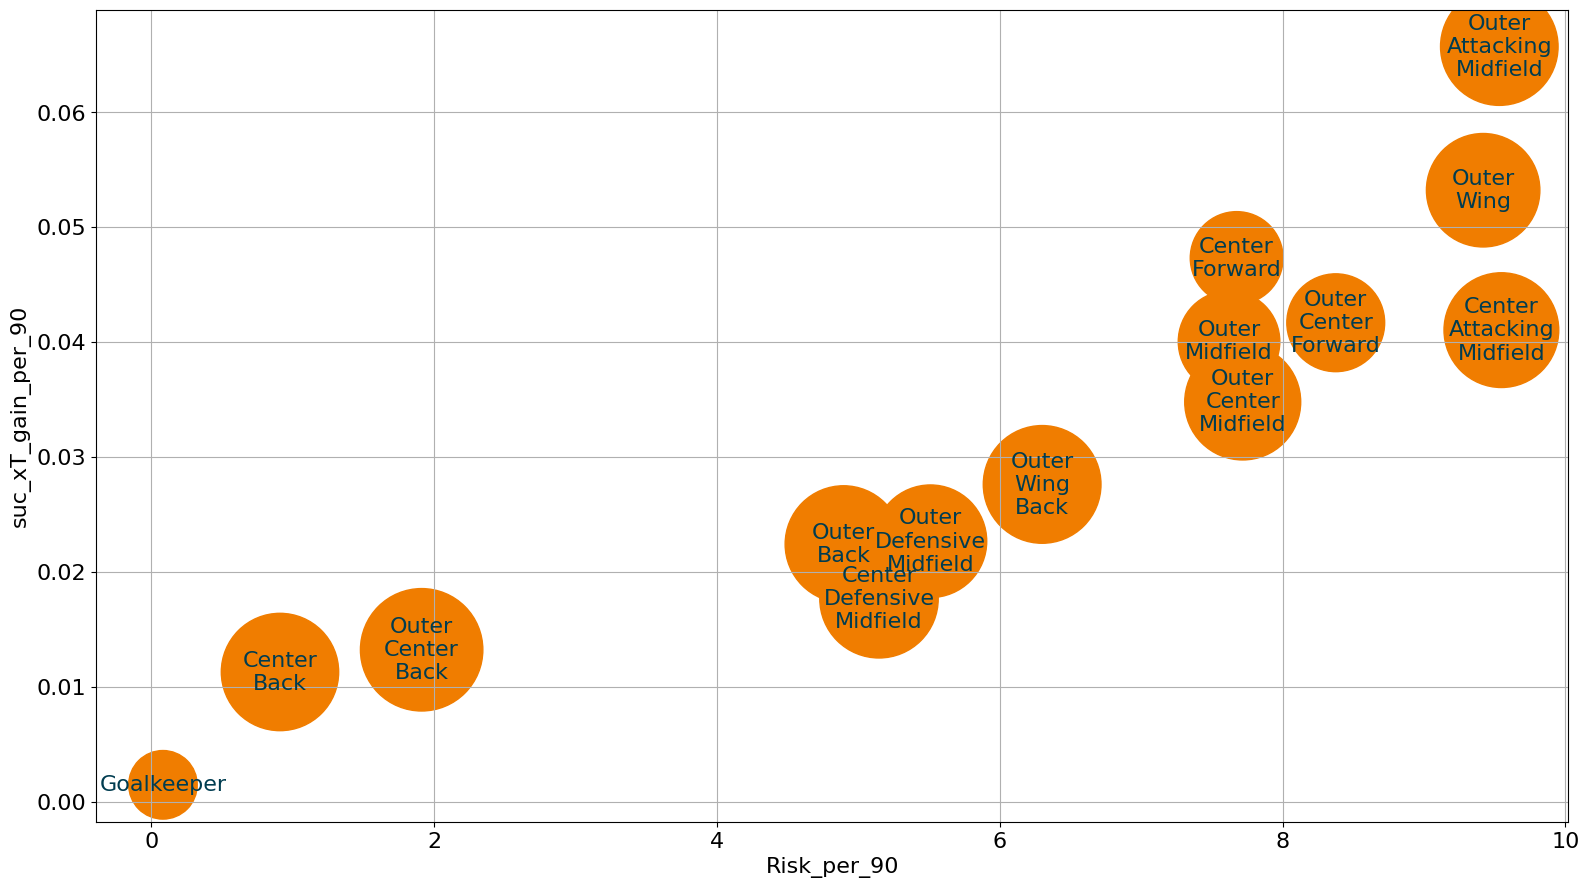

In [31]:
temp = positions.copy()
temp.rename(columns = {"xT_gain_nonnegative_per_90": "suc_xT_gain_per_90"}, inplace=True)
fig = scatterplot_with_groupby(temp, "Risk_per_90", "suc_xT_gain_per_90", "position_ignoring_side", size_col = "num_carries_per_90")
fig.savefig("graphics/comparison_risk_xt_different_positions.png", bbox_inches='tight', dpi=1000)


# Evaluation of top players

In [32]:
player_teams = carries[["player_name", "team_name"]].drop_duplicates()

In [33]:
total_vals.sort_values("playing_time_in_minutes", ascending=False).to_excel("all_players_all_values.xlsx")

In [34]:
player_vals_with_minimum_60_min = total_vals[total_vals["playing_time_in_minutes"]>=90]
player_vals_with_minimum_60_min.sort_values("playing_time_in_minutes", ascending=False).to_excel("players_with_min_60_min_all_values.xlsx")

In [35]:
relevant_columns = ["player_name", "team_name", "position_name", "playing_time_in_minutes"] + [col for col in player_vals_with_minimum_60_min if "per_90" in col and "Norm" not in col]

In [36]:
final_df = player_vals_with_minimum_60_min[relevant_columns]

In [37]:
temp = player_vals_with_minimum_60_min.sort_values("XT_Gain_over_Expectation", ascending=False).head(5)[["player_name", "team_name", "position_name", "XT_Gain_over_Expectation"]]
temp["player_name_info"] = temp['player_name'] + '\n (' + temp['team_name'].str[:-8] + ", " + temp['position_name'] + ')'
temp.reset_index(inplace=True, drop=True)
temp.rename(columns = {"XT_Gain_over_Expectation": "Total xT Gain over Expectation"}, inplace=True)
temp

,player_name,team_name,position_name,Total xT Gain over Expectation,player_name_info
0,Aitana Bonmati Conca,Spain Women's,Right Center Midfield,0.982925,"Aitana Bonmati Conca\n (Spain, Right Center Mi..."
1,Fridolina Rolfö,Sweden Women's,Left Wing,0.572302,"Fridolina Rolfö\n (Sweden, Left Wing)"
2,Teresa Abelleira Dueñas,Spain Women's,Center Defensive Midfield,0.506136,"Teresa Abelleira Dueñas\n (Spain, Center Defen..."
3,Jennifer Hermoso Fuentes,Spain Women's,Left Center Midfield,0.474532,"Jennifer Hermoso Fuentes\n (Spain, Left Center..."
4,Ingrid Filippa Angeldal,Sweden Women's,Right Defensive Midfield,0.465028,"Ingrid Filippa Angeldal\n (Sweden, Right Defen..."


<Figure size 19200x14400 with 0 Axes>

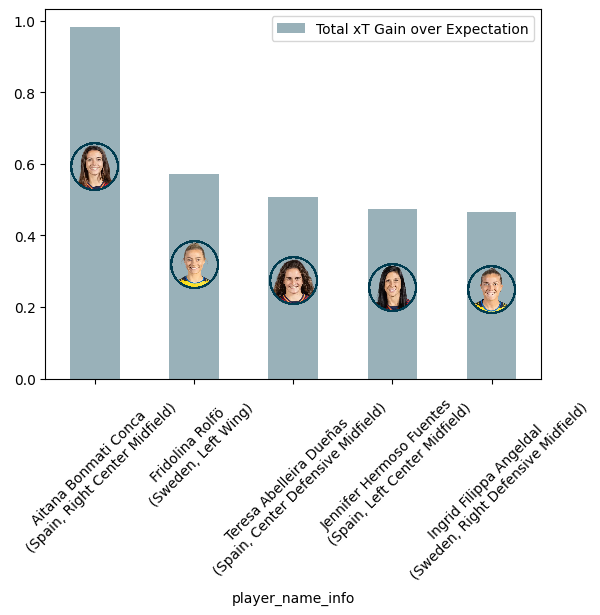

In [38]:
plt.figure(dpi=3000)

bar_plot = temp.plot.bar(x="player_name_info", y="Total xT Gain over Expectation", color = grey)
plt.xticks(rotation=45)


# assume portraits available as pictures/<player_name>.webp
for x, row in temp.iterrows():
    offset_image(x, row["Total xT Gain over Expectation"]*2/3,  row["player_name"], ax=plt.gca())

bar_fig = bar_plot.get_figure()
bar_fig.savefig("graphics/top_player_xt_gain_over_expectation.png", bbox_inches='tight', dpi=1000)


In [39]:
with pd.ExcelWriter('final_evaluation.xlsx') as writer:  
    final_df.to_excel(writer, sheet_name="all_players", index=False)
    final_df.sort_values("xT_gain_per_90", ascending=False).head(20).to_excel(writer, sheet_name = "Groeßter XT_Gewinn", index=False)
    final_df.sort_values("Outcome_over_Risk_per_90", ascending=False).head(20).to_excel(writer, sheet_name = "Erfolgsrate im Vgl. Risiko", index=False)
    final_df.sort_values("advance_diff_per_90", ascending=False).head(20).to_excel(writer, sheet_name = "Groeßte Gesamtdistanz", index=False)
    final_df.sort_values("Risk_per_90", ascending=False).head(20).to_excel(writer, sheet_name = "Groeßtes Gesamtrisiko", index=False)
    final_df.sort_values("Pressure_Delta_per_90", ascending=False).head(20).to_excel(writer, sheet_name = "Beste Druckloeser", index=False)

In [40]:
final_df

,player_name,team_name,position_name,playing_time_in_minutes,xt_norm_per_90,Pressure_Delta_per_90,advance_diff_per_90,xT_gain_per_90,Risk_per_90,Outcome_over_Risk_per_90,num_carries_per_90,xT_gain_nonnegative_per_90
0,Ada Stolsmo Hegerberg,Norway Women's,Center Forward,90.000000,8.168190,-1.583794,22.518368,-0.017396,4.314691,1.314691,12.000000,0.007227
2,Adriana Leal da Silva,Brazil Women's,Left Midfield,168.766667,28.842200,2.343679,183.577651,0.061245,10.746510,4.347142,42.129172,0.113851
3,Adriana María Sachs,Argentina Women's,Right Center Back,90.000000,4.778528,1.081931,3.412025,0.000008,0.572753,0.572753,7.000000,0.000478
4,Agness Musase,Zambia Women's,Right Center Back,262.433333,9.363902,0.821357,15.268124,-0.000346,0.549254,0.206310,13.717770,0.001394
5,Aitana Bonmati Conca,Spain Women's,Right Center Midfield,571.900000,41.482796,1.918169,110.219831,0.011514,13.059895,8.338790,60.744885,0.116450
...,...,...,...,...,...,...,...,...,...,...,...,...
547,Young-Geul Yoon,Korea Republic Women's,Goalkeeper,90.000000,2.049069,0.000000,29.899636,0.000837,0.003165,0.003165,3.000000,0.000974
548,Yu Zhu,China PR Women's,Goalkeeper,90.000000,8.876781,-0.365259,62.411467,0.001767,0.003380,0.003380,13.000000,0.002078
549,Yui Hasegawa,Japan Women's,Right Defensive Midfield,322.116667,38.732168,4.654684,78.455863,0.009970,9.490506,7.255291,56.718580,0.061546
550,Zecira Musovic,Sweden Women's,Goalkeeper,540.000000,6.486085,-0.214502,27.485478,0.000705,0.074839,0.074839,9.500000,0.000939


# Individual player analysis

In [41]:
final_df["Outcome_over_Risk_rank"] = final_df["Outcome_over_Risk_per_90"].rank(ascending=False)
final_carries = carries.merge(final_df[["player_name", "Outcome_over_Risk_rank", "team_name", "position_name"]], how = "left", validate = "many_to_one")

In [42]:
use_case2_prehelper = final_carries.merge(final_df[["player_name", "team_name", "position_name"]], validate = "many_to_one")
use_case2_helper =use_case2_prehelper.groupby(["player_name","team_name", "position_name"])["Outcome_over_Risk"].median().rank( ascending=False)
final_carries = final_carries.merge(use_case2_helper, how = "left", left_on = ["player_name", "team_name", "position_name"],
                                    right_index=True, validate = "many_to_one", suffixes = ("", "_median_rank"))


In [43]:
final_carries_top_players = final_carries[final_carries["Outcome_over_Risk_rank"]<=5]

In [44]:
final_carries_top_players[["player_name" ,"Outcome_over_Risk_rank", "team_name", "position_name"]].drop_duplicates()

,player_name,Outcome_over_Risk_rank,team_name,position_name
2806,Jennifer Hermoso Fuentes,3.0,Spain Women's,Left Center Midfield
9351,Estefanía Romina Banini Ruiz,1.0,Argentina Women's,Center Attacking Midfield
12671,Hina Sugita,5.0,Japan Women's,Left Wing Back
13428,Hinata Miyazawa,2.0,Japan Women's,Left Attacking Midfield
38414,Lindsey Michelle Horan,4.0,United States Women's,Center Attacking Midfield


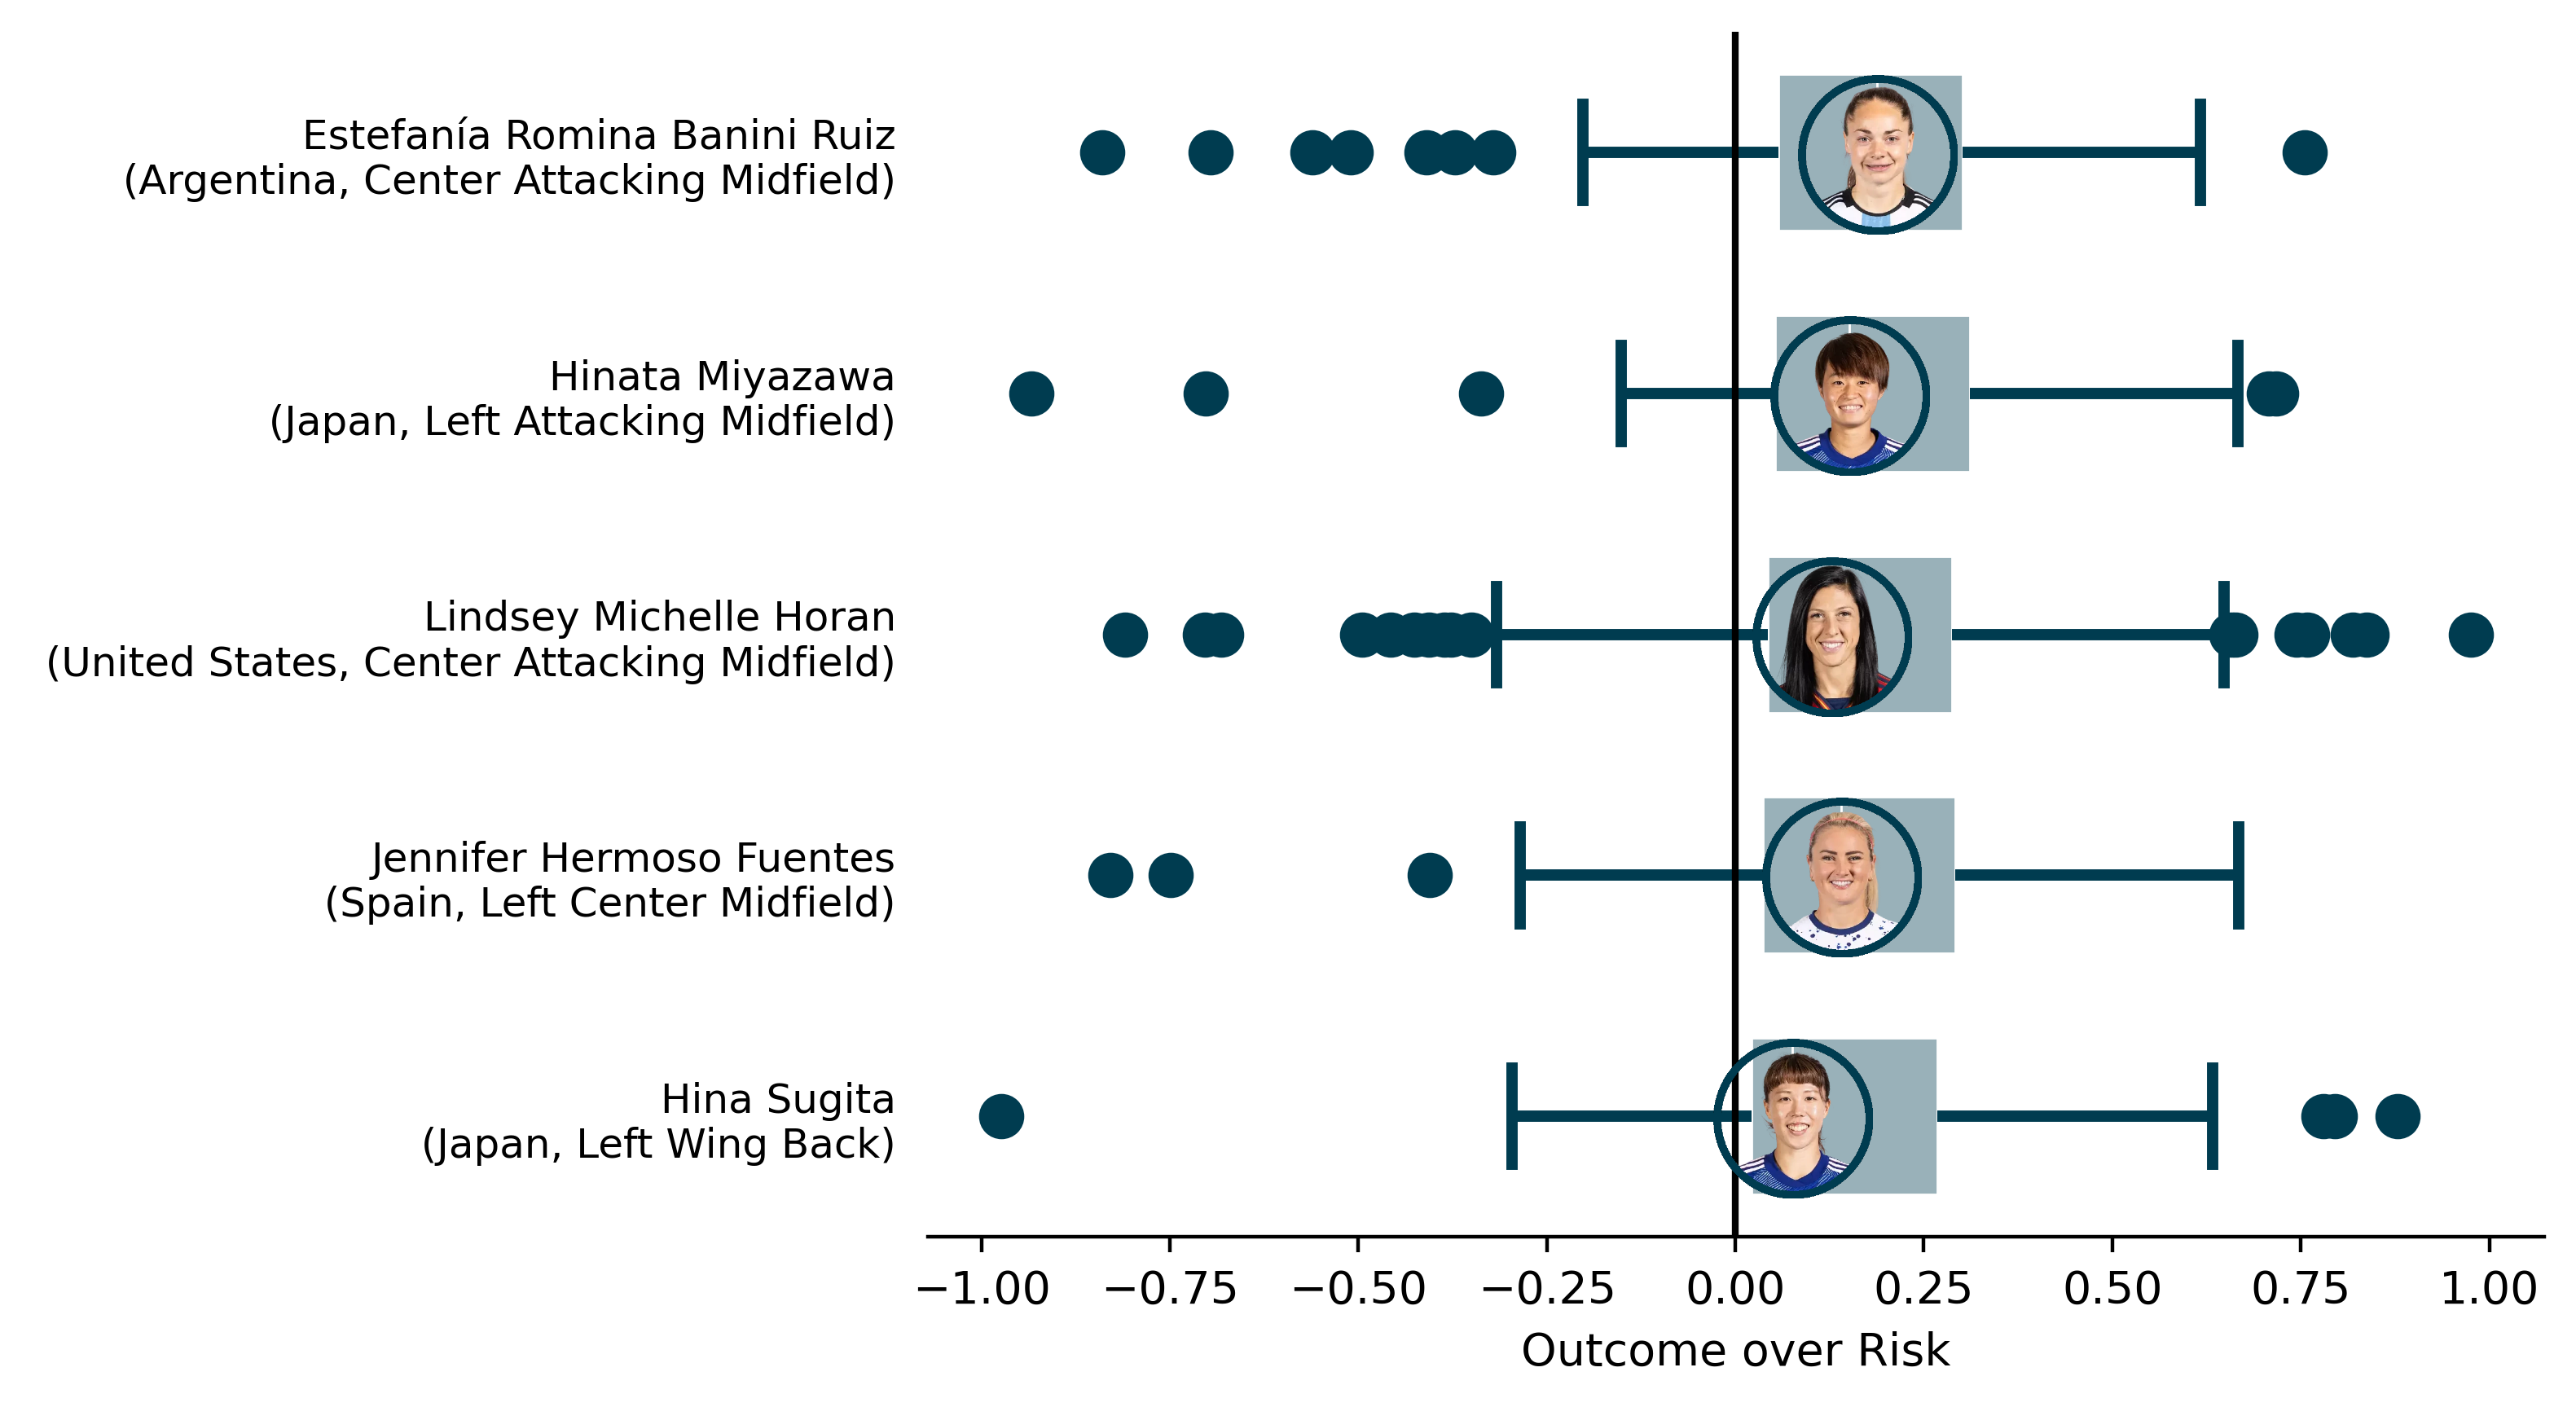

In [45]:

#set new seaborn style
sns.set_style(style={'axes.spines.right': False,
                    'axes.spines.top': False,
                    'axes.spines.left': False,
                    #'axes.spines.bottom': False,
                    #'xtick.bottom': False,
                    'ytick.left': False,
                    'axes.labels': False})
plt.figure(dpi=400)

box_plot = sns.boxplot(x="Outcome_over_Risk",y="Outcome_over_Risk_rank",data=final_carries_top_players, orient='h', 
                       color=orange, 
                       linecolor=blue,
#                       linewidth=2,
                       flierprops = dict(marker='o', markerfacecolor=blue, markersize=9,
                  linestyle='none', markeredgecolor=blue),
                       widths=0.650, patch_artist=True,
                showmeans=False, showfliers=True,
                medianprops={"color": "white", "linewidth": 0.5},
                boxprops={"facecolor": grey, "edgecolor": "white",
                          "linewidth": 0.5},
                whiskerprops={"color": blue, "linewidth": 2.5},
                capprops={"color": blue, "linewidth": 2.5}
                      )

player_names_ranked = [name[1]['player_name'].iloc[0] 
                       for name in final_carries_top_players[["player_name" ,"Outcome_over_Risk_rank"]].drop_duplicates().groupby("Outcome_over_Risk_rank", observed=True)]
player_names_info = [name[1]['player_name'].iloc[0] + '\n (' + name[1]['team_name'].iloc[0][:-8] + ", " + name[1]['position_name'].iloc[0] + ')' 
                     for name in final_carries_top_players[["player_name" ,"Outcome_over_Risk_median_rank", "team_name", "position_name"]].drop_duplicates().groupby("Outcome_over_Risk_median_rank", observed=True)]
box_plot.set(xlabel="Outcome over Risk", ylabel=""# title ="Top 5 players ",
            #xticklabels ="0", 
            )
box_plot.set_yticklabels(player_names_info, size=9)
box_plot.axvline(0, color=black)



medians = final_carries_top_players.groupby(['Outcome_over_Risk_rank'], observed=True)['Outcome_over_Risk'].median()

ax = box_plot.axes
vertical_offset = 0.29
# assume portraits available as pictures/<player_name>.webp
for ytick in box_plot.get_yticks():
    offset_image(medians.iloc[ytick], ytick - vertical_offset, player_names_ranked[ytick], ax)
##################

# Save figure
box_fig = box_plot.get_figure()
box_fig.savefig("graphics/top_players_usecase1.png", bbox_inches='tight')

# reset seaborn style
sns.set_style(style=None)


<Axes: xlabel='player_name'>

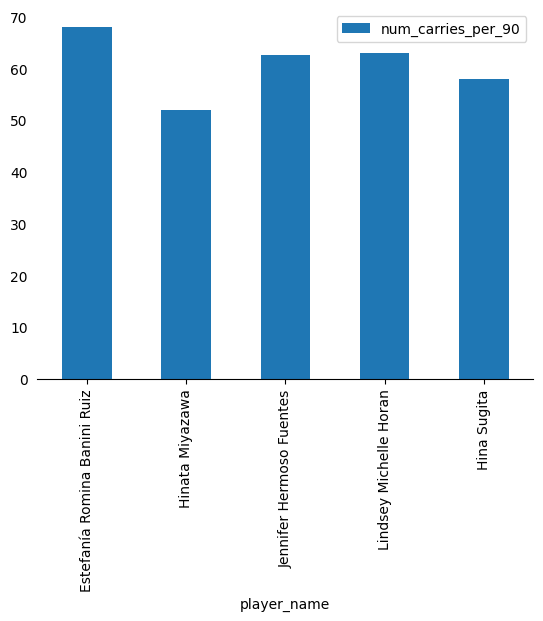

In [46]:
final_df.sort_values("Outcome_over_Risk_rank", ascending=True).head(5).plot.bar( "player_name" , "num_carries_per_90")

<Axes: xlabel='player_name'>

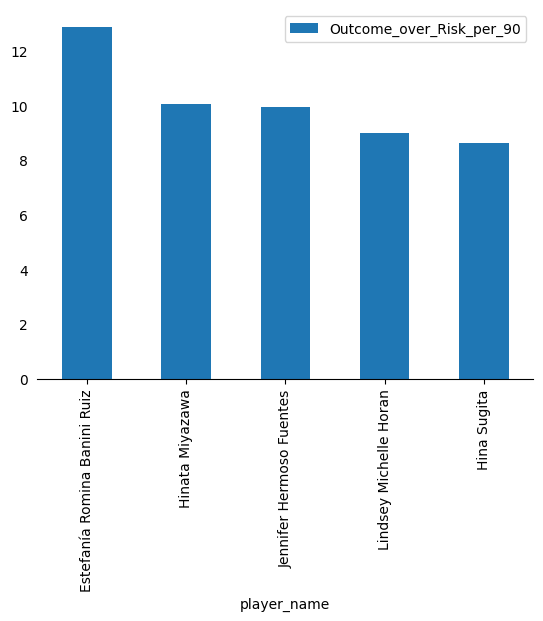

In [47]:
final_df.sort_values("Outcome_over_Risk_rank", ascending=True).head(5).plot.bar("player_name", "Outcome_over_Risk_per_90" )

In [48]:
use_case2 = final_carries[final_carries["Outcome_over_Risk_median_rank"]<=5]


<Axes: xlabel='player_name'>

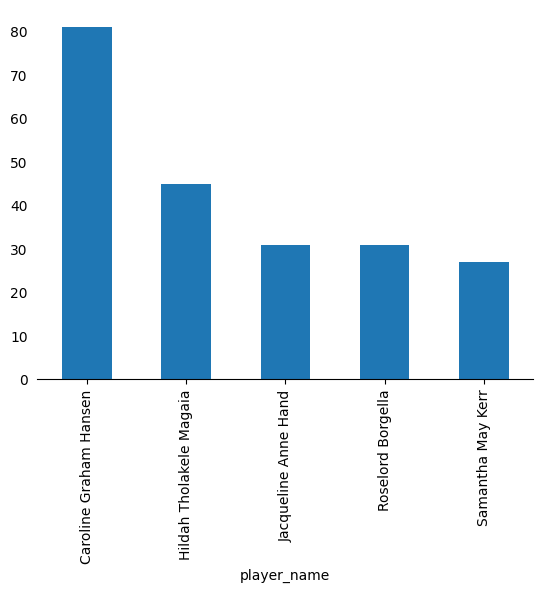

In [49]:
use_case2.groupby("player_name").sum()["num_carries"].plot.bar()

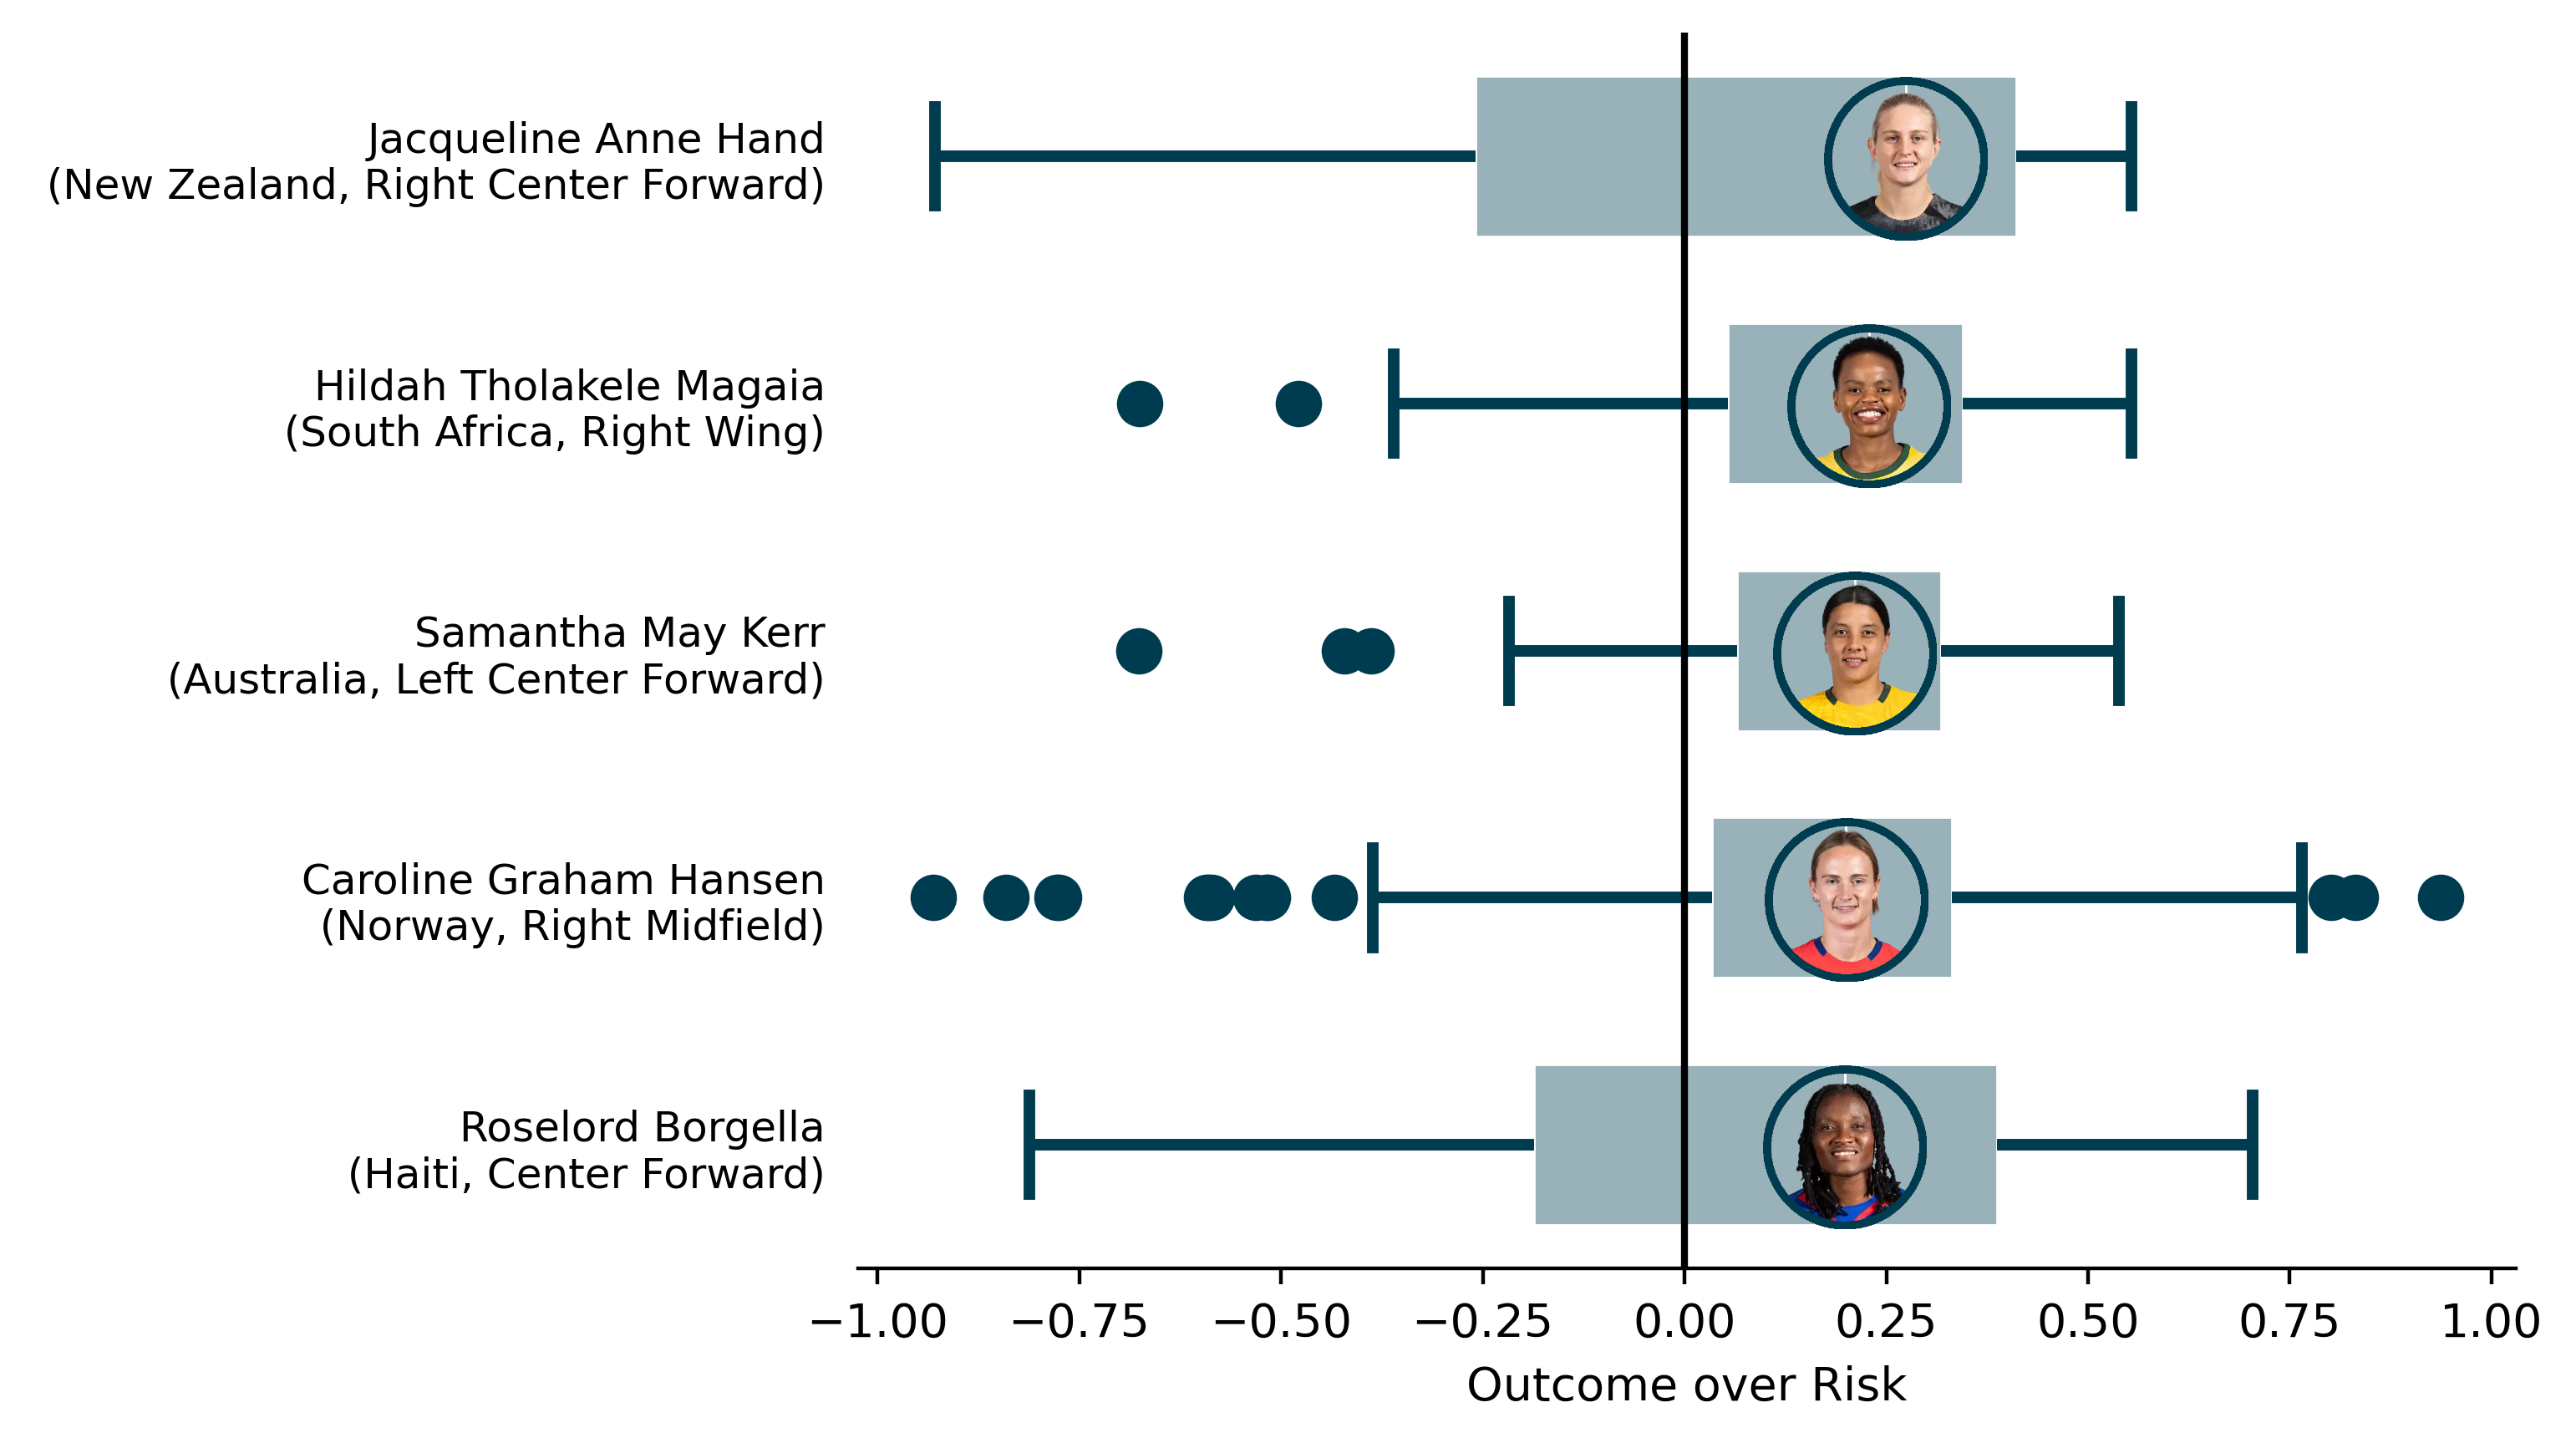

In [50]:
#set new seaborn style
sns.set_style(style={'axes.spines.right': False,
                    'axes.spines.top': False,
                    'axes.spines.left': False,
                    #'axes.spines.bottom': False,
                    #'xtick.bottom': False,
                    'ytick.left': False,
                    'axes.labels': False})
plt.figure(dpi=400)

box_plot = sns.boxplot(x="Outcome_over_Risk",y="Outcome_over_Risk_median_rank",data=use_case2, orient='h', 
                       color=orange, 
                       linecolor=blue,
#                       linewidth=2,
                       flierprops = dict(marker='o', markerfacecolor=blue, markersize=9,
                  linestyle='none', markeredgecolor=blue),
                       widths=0.650, patch_artist=True,
                showmeans=False, showfliers=True,
                medianprops={"color": "white", "linewidth": 0.5},
                boxprops={"facecolor": grey, "edgecolor": "white",
                          "linewidth": 0.5},
                whiskerprops={"color": blue, "linewidth": 2.5},
                capprops={"color": blue, "linewidth": 2.5}
                      )

player_names_ranked = [name[1]['player_name'].iloc[0] for name in use_case2[["player_name" ,"Outcome_over_Risk_median_rank"]].drop_duplicates().groupby("Outcome_over_Risk_median_rank", observed=True)]
player_names_info = [name[1]['player_name'].iloc[0] + '\n (' + name[1]['team_name'].iloc[0][:-8] + ", " + name[1]['position_name'].iloc[0] + ')' 
                     for name in use_case2[["player_name" ,"Outcome_over_Risk_median_rank", "team_name", "position_name"]].drop_duplicates().groupby("Outcome_over_Risk_median_rank", observed=True)]


box_plot.set(xlabel="Outcome over Risk", ylabel="",# title ="Top 5 players ",
            #xticklabels ="0"
            )
box_plot.set_yticklabels(player_names_info, size=9)
box_plot.axvline(0, color=black)

##################
# Insert portraits
medians = use_case2.groupby(['Outcome_over_Risk_median_rank'], observed=True)['Outcome_over_Risk'].median()

ax = box_plot.axes
# assume portraits available as pictures/<player_name>.webp
for ytick in box_plot.get_yticks():
    offset_image(medians.iloc[ytick], ytick - vertical_offset, player_names_ranked[ytick], ax)
##################

# Save figure
box_fig = box_plot.get_figure()
box_fig.savefig("graphics/top_players_usecase2.png", bbox_inches='tight')

# reset seaborn style
sns.set_style(style=None)
